# Шаг 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# Функция для вывода свойств датафрэйма
def df_info(df):
    #display(df.describe())
    display(df.head())
    df.info()
    print()
    print('Кол-во дубликатов = ', df.duplicated().sum())    

Загружаем датасеты

In [4]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

Посмотрим на датасеты: 

In [9]:
df_info(visits)
df_info(orders)
df_info(costs)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

Кол-во дубликатов =  0


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB

Кол-во дубликатов =  0


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB

Кол-во дубликатов =  0


Из предварительного просмотра видно:
1. Пропуски отсутствуют, дубликаты отсутствуют.
2. В названиях столбцов следует убрать пробелы и заглавные буквы для удобства
3. надо присвоить столбцам со временем тип данных datetime

1. Меняем названия столбцов:

In [6]:
visits.columns = [ name.replace(' ', '_').lower() for name in  visits.columns]
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [7]:
orders.columns = [ name.replace(' ', '_').lower() for name in  orders.columns]
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

2. Присваиваем столбцам со временем тип данных datetime

In [8]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

costs['dt'] = pd.to_datetime(costs['dt'])

# Шаг 2. Построение отчётов и расчет метрик

# 2.1 Продукт

## 2.1.1 Сколько людей пользуются в день, неделю, месяц?

Создадим дополнительные столбцы, соответствующие дню, неделе, месяцу, когда было начало сессии

In [9]:
visits['start_ts_day'] = visits['start_ts'].astype('datetime64[D]')

visits['start_ts_week'] = (pd.to_datetime(
    visits['start_ts'], unit='d') - pd.to_timedelta(
    visits['start_ts'].dt.dayofweek, unit='d')).astype('datetime64[D]')

visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]')
visits.head(2)

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01


Далее группируем таблицу по соответствующему временному интервалу и получаем количество уникальных пользователей в данный интервал.

# ДЕНЬ

In [10]:
df0 = visits.groupby('start_ts_day')['uid'].nunique().reset_index()
df0.head(2)

,start_ts_day,uid
0,2017-06-01,605
1,2017-06-02,608


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Количество посетителей в день')

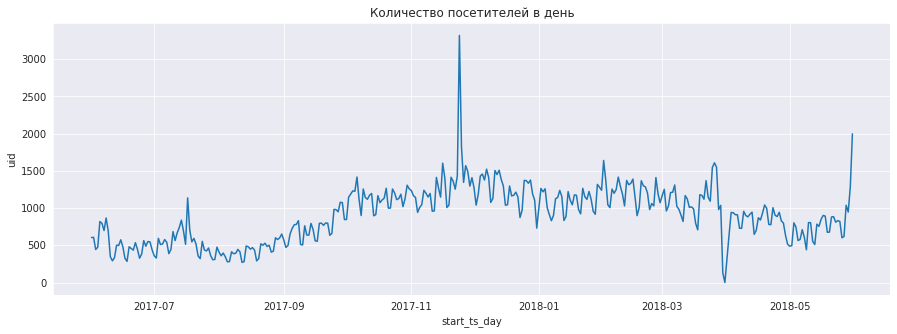

In [11]:
plt.figure(figsize=(15,5))
a = sns.lineplot(data=df0, x='start_ts_day', y='uid')
a.set_title('Количество посетителей в день')

In [12]:
visits_per_day_mean = round(df0.uid.mean(),2)
print('Среднее количество посетителей в день =',visits_per_day_mean)

Среднее количество посетителей в день = 907.99


In [13]:
print('Максимальное количество посетителей в день: ',df0['uid'].max())
print('Минимальное количество посетителей в день: ',df0['uid'].min())

Максимальное количество посетителей в день:  3319
Минимальное количество посетителей в день:  1


# НЕДЕЛИ

In [14]:
df1 = visits.groupby('start_ts_week')['uid'].nunique().reset_index()
df1.head(2)

,start_ts_week,uid
0,2017-05-29,2021
1,2017-06-05,4129


Text(0.5, 1.0, 'Количество посетителей в неделю')

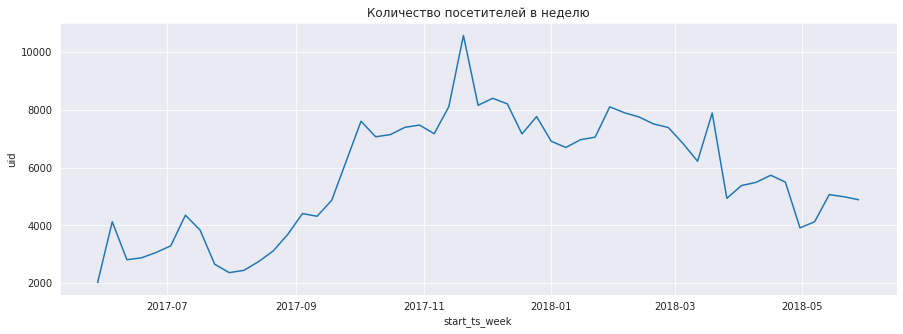

In [15]:
plt.figure(figsize=(15,5))
a = sns.lineplot(data=df1, x='start_ts_week', y='uid')
a.set_title('Количество посетителей в неделю')

In [16]:
visits_per_week_mean = round(df1.uid.mean(),2)
print('Среднее количество посетителей в неделю =',visits_per_week_mean)

Среднее количество посетителей в неделю = 5716.25


In [17]:
print('Максимальное количество посетителей в неделю: ',df1['uid'].max())
print('Минимальное количество посетителей в неделю: ',df1['uid'].min())

Максимальное количество посетителей в неделю:  10586
Минимальное количество посетителей в неделю:  2021


# МЕСЯЦЫ

In [18]:
visits.head(2)

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01


In [19]:
df2 = visits.groupby('start_ts_month')['uid'].nunique().reset_index()
df2.head(2)

,start_ts_month,uid
0,2017-06-01,13259
1,2017-07-01,14183


Text(0.5, 1.0, 'Количество посетителей в месяц')

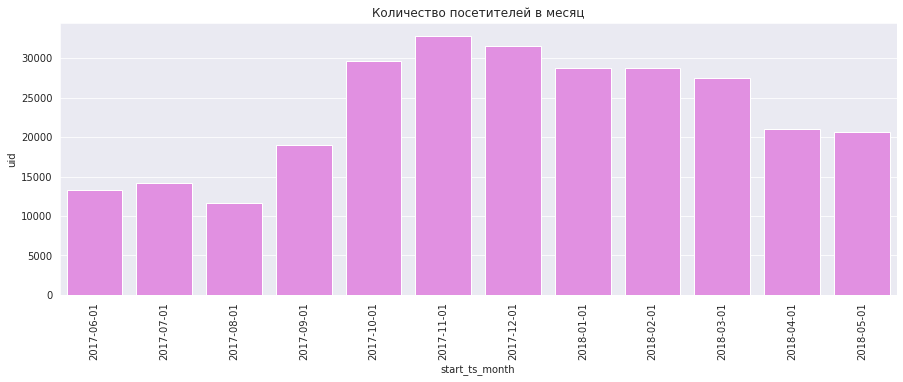

In [20]:
plt.figure(figsize=(15,5))
a = sns.barplot(data=df2, x='start_ts_month', y='uid', color='violet')
a.set_xticklabels(df2.start_ts_month.apply(lambda x: x.date()),rotation=90)
a.set_title('Количество посетителей в месяц')

In [21]:
visits_per_month_mean = round(df2.uid.mean(),2)
print('Среднее количество посетителей в месяц =',visits_per_month_mean)

Среднее количество посетителей в месяц = 23228.42


In [22]:
print('Максимальное количество посетителей в месяц: ',df2['uid'].max())
print('Минимальное количество посетителей в месяц: ',df2['uid'].min())

Максимальное количество посетителей в месяц:  32797
Минимальное количество посетителей в месяц:  11631


Выводы: 
- наблюдается низкое посещение летом (минимум в июле) и высокое посещение осенью/зимой (максимум в ноябре).  
- 2017-11-24: наблюдается аномально высокое посещение - 3319 при среднем значении 908 сессий/сутки
- 2018-03-31: зафиксировано всего одно посещение. 

## 2.1.2 Сколько сессий в день?

Тут имеется ввиду сколько сессий в среднем совершает 1 пользователь в день

Получим таблицу, в которой для каждого дня будет указано количество сессий и количество уникальных пользователей. Зная эти 2 величины можем вычислить число сессий в день на одного пользователя

In [23]:
df3 = visits.groupby('start_ts_day')['start_ts'].count().reset_index()
df3.rename(columns={'start_ts':'n_sessions'}, inplace=True)
df3.head(2)

,start_ts_day,n_sessions
0,2017-06-01,664
1,2017-06-02,658


In [24]:
df3 = df3.merge(df0, on='start_ts_day', how='left')
df3.rename(columns={'uid':'n_users'}, inplace=True)
df3.head(2)

,start_ts_day,n_sessions,n_users
0,2017-06-01,664,605
1,2017-06-02,658,608


Вычисляем число сессий в день на одного пользователя

In [25]:
df3['session_per_users'] = df3['n_sessions'] / df3['n_users']
df3.head(2)

,start_ts_day,n_sessions,n_users,session_per_users
0,2017-06-01,664,605,1.097521
1,2017-06-02,658,608,1.082237


Text(0.5, 1.0, 'Количество сессий день на одного пользователя')

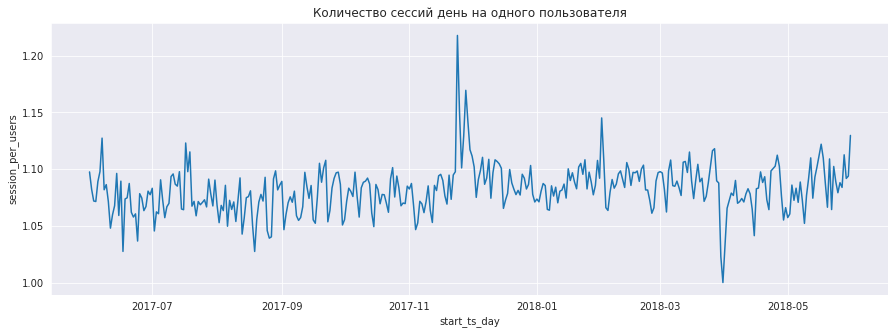

In [26]:
plt.figure(figsize=(15,5))
a = sns.lineplot(data=df3, x='start_ts_day', y='session_per_users')
a.set_title('Количество сессий день на одного пользователя')

In [27]:
session_per_day_mean = round(df3.session_per_users.mean(),2)
print('Среднее количество сессий в день на одного пользователя =', session_per_day_mean)

Среднее количество сессий в день на одного пользователя = 1.08


Вывод: среднее количество сессий в сутки на одного пользователя в целом находится на одном уровне (имеется шум, но около одного среднего значения). Имеется 1 пик максимума и 1 пик минимума, связанные с посещаемостью (разобрано выже)

## 2.1.3 Сколько длится одна сессия?

Сперва проверим, что у нас время окончания выше чем время начала сессии:

In [28]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 8 columns):
device            359400 non-null object
end_ts            359400 non-null datetime64[ns]
source_id         359400 non-null int64
start_ts          359400 non-null datetime64[ns]
uid               359400 non-null uint64
start_ts_day      359400 non-null datetime64[ns]
start_ts_week     359400 non-null datetime64[ns]
start_ts_month    359400 non-null datetime64[ns]
dtypes: datetime64[ns](5), int64(1), object(1), uint64(1)
memory usage: 21.9+ MB


In [29]:
visits[visits['end_ts'] < visits['start_ts']]

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-25,2018-03-19,2018-03-01
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-25,2018-03-19,2018-03-01


In [30]:
visits[visits['end_ts'] == visits['start_ts']]

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01
28,desktop,2017-11-09 15:53:00,4,2017-11-09 15:53:00,17892541477379911957,2017-11-09,2017-11-06,2017-11-01
32,desktop,2017-11-30 12:29:00,4,2017-11-30 12:29:00,13410401624913285510,2017-11-30,2017-11-27,2017-11-01
54,desktop,2018-02-23 16:52:00,10,2018-02-23 16:52:00,13423278602430425332,2018-02-23,2018-02-19,2018-02-01
...,...,...,...,...,...,...,...,...
358511,desktop,2017-09-15 11:31:00,4,2017-09-15 11:31:00,6406595666419694649,2017-09-15,2017-09-11,2017-09-01
358514,desktop,2018-01-16 23:57:00,5,2018-01-16 23:57:00,6457848932283204350,2018-01-16,2018-01-15,2018-01-01
358522,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017-11-08,2017-11-06,2017-11-01
358524,touch,2018-01-18 13:38:00,4,2018-01-18 13:38:00,4558073034499185861,2018-01-18,2018-01-15,2018-01-01


Обнаружили 35794 строк (10% от общего объема), у которых время начала и конца сессии совпадает. Такие варианты возможны, оставляем такие данные.   
Также обнаружили 2 строки, где время окончания раньше, чем время начала сессии. Это явные ошибки.  Не будем удалять эти строки, но запоминаем что они есть и учитываем при дальнейшем анализе. Следует сообщить об ошибке в источник данных

Вычисляем продлжительность сессии

In [31]:
visits['duration_ts'] = visits['end_ts'] - visits['start_ts']
visits['duration_ts_seconds'] = visits['duration_ts'].astype('timedelta64[s]')

Text(0.5, 1.0, 'Гистограмма продолжительности сессии')

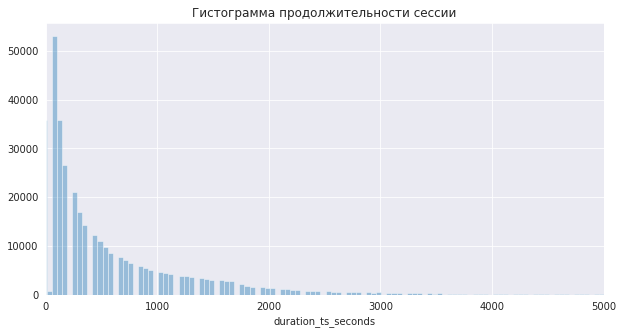

In [32]:
plt.figure(figsize=(10,5))
a = sns.distplot(visits['duration_ts_seconds'], kde=False, bins=1000)
a.set_xlim(0,5000)
a.set_title('Гистограмма продолжительности сессии')

In [33]:
duration_ts_mean = visits['duration_ts_seconds'].mean()
duration_ts_median = visits['duration_ts_seconds'].median()
duration_ts_mode = visits['duration_ts_seconds'].mode()

print('Средняя продолжительность сессии, сек =', duration_ts_mean)
print('Медиана продолжительности сессии, сек =', duration_ts_median)
print('Мода продолжительности сессии, сек =', duration_ts_mode)

Средняя продолжительность сессии, сек = 643.0256872565387
Медиана продолжительности сессии, сек = 300.0
Мода продолжительности сессии, сек = 0    60.0
dtype: float64


Вывод: на гистограмме есть выбросы, поэтому в качестве средней продолжительности сессии следует выбрать медианное значение = 300 сек

## 2.1.4 Как часто люди возвращаются? 

## В качестве ответа на данный вопрос вычислим RETENTION RATE по когортам, сгруппированным по месяцам

Для вычисления RETENTION RATE по месяцам необходимо вычислить месяц первого посещения для каждого пользователя.

## !!! для удобства сперва найдем просто дату первого посещения (понадобится в будущих расчетах), а уже из нее выделим месяц первого посещения !!!

In [34]:
visits_first_start_ts = visits.groupby('uid')['start_ts'].min()
visits_first_start_ts.name = 'first_start_ts'
visits_first_start_ts.head(2)

uid
11863502262781   2018-03-01 17:27:00
49537067089222   2018-02-06 15:55:00
Name: first_start_ts, dtype: datetime64[ns]

In [35]:
visits = visits.merge(visits_first_start_ts, on='uid', how='left')

In [36]:
visits['first_start_ts_month'] = visits['first_start_ts'].astype('datetime64[M]')
visits.head(2)

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month,duration_ts,duration_ts_seconds,first_start_ts,first_start_ts_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,00:18:00,1080.0,2017-12-20 17:20:00,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,00:28:00,1680.0,2018-02-19 16:53:00,2018-02-01


Вычислим lifetime для каждой когорты

In [37]:
visits['cohort_lifetime'] = visits['start_ts'] - visits['first_start_ts_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype('int')
visits.head(5)

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month,duration_ts,duration_ts_seconds,first_start_ts,first_start_ts_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,00:18:00,1080.0,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,00:28:00,1680.0,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01,00:00:00,0.0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,00:24:00,1440.0,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01,00:00:00,0.0,2017-12-27 14:06:00,2017-12-01,0


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:

In [38]:
cohorts_visits = visits.groupby(['first_start_ts_month',
                              'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts_visits.rename(columns={'uid':'n_users'}, inplace=True)
cohorts_visits.head(2)

,first_start_ts_month,cohort_lifetime,n_users
0,2017-06-01,0,13259
1,2017-06-01,1,1030


In [39]:
cohorts_visits.query('cohort_lifetime == 0  & first_start_ts_month == "2017-06-01"')

,first_start_ts_month,cohort_lifetime,n_users
0,2017-06-01,0,13259


Найдем исходное количество пользователей в каждой когорте:

In [40]:
initial_users_count = cohorts_visits.query('cohort_lifetime == 0')[['first_start_ts_month','n_users']]
initial_users_count = initial_users_count.rename(columns={'n_users':'cohort_users'})
initial_users_count.head(2)

,first_start_ts_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,12856


Объединим данные по когортам с исходным количеством пользователей в когорте:

In [41]:
cohorts_visits = cohorts_visits.merge(initial_users_count,on='first_start_ts_month', how='left')
cohorts_visits.head(2)

,first_start_ts_month,cohort_lifetime,n_users,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1030,13259


In [42]:
cohorts_visits['n_users'].sum()

278741

In [43]:
cohorts_visits.query('cohort_lifetime == 0')

,first_start_ts_month,cohort_lifetime,n_users,cohort_users
0,2017-06-01,0,13259,13259
12,2017-07-01,0,12856,12856
24,2017-08-01,0,9749,9749
34,2017-09-01,0,16704,16704
43,2017-10-01,0,25256,25256
51,2017-11-01,0,27248,27248
58,2017-12-01,0,24882,24882
64,2018-01-01,0,21945,21945
69,2018-02-01,0,22197,22197
73,2018-03-01,0,20588,20588


Наконец, рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте:

In [44]:
cohorts_visits['retention_rate'] = cohorts_visits['n_users'] / cohorts_visits['cohort_users']
cohorts_visits.head(2)

,first_start_ts_month,cohort_lifetime,n_users,cohort_users,retention_rate
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1030,13259,0.077683


In [45]:
retention_pivot = cohorts_visits.pivot_table(index = 'first_start_ts_month', columns = 'cohort_lifetime',
                                     values = 'retention_rate')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_start_ts_month,,,,,,,,,,,,
2017-06-01,1.0,0.077683,0.051814,0.062901,0.067803,0.072404,0.061769,0.055887,0.055585,0.049778,0.041255,0.044347
2017-07-01,1.0,0.077551,0.053438,0.056394,0.060750,0.049860,0.045348,0.050249,0.039281,0.029325,0.027769,0.000544
2017-08-01,1.0,0.121859,0.063186,0.066879,0.052210,0.045133,0.041132,0.039491,0.029644,0.026567,NaN,NaN
2017-09-01,1.0,0.084471,0.069504,0.050347,0.038733,0.040769,0.033645,0.024784,0.022150,NaN,NaN,NaN
2017-10-01,1.0,0.109202,0.053690,0.039040,0.038644,0.031834,0.022173,0.020787,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.077400,0.043343,0.041838,0.031745,0.024222,0.021066,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.070975,0.041315,0.030584,0.020979,0.018929,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.094919,0.037548,0.026156,0.020369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.050457,0.025769,0.019462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Отобразим результат на тепловой карте:

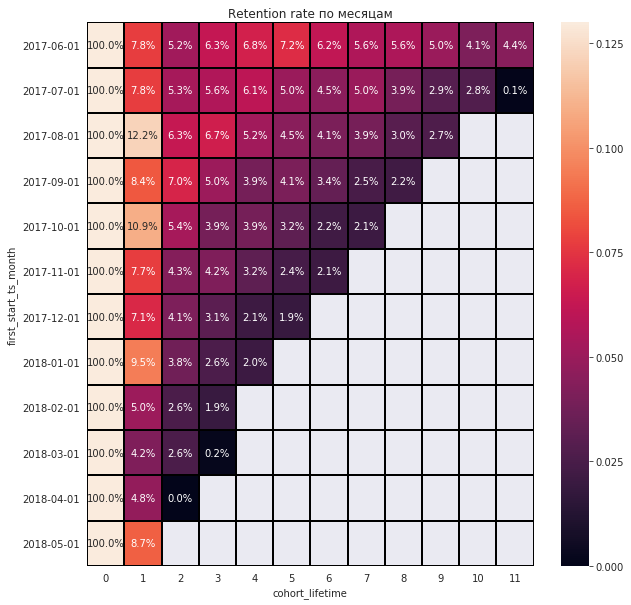

In [46]:
plt.figure(figsize=(10, 10))
plt.title('Retention rate по месяцам')
a = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black',
               vmin = 0, vmax = 0.13, 
                yticklabels = df2.start_ts_month.apply(lambda x: x.date()));

Также покажем изменение среднего по когортам RR во времени, начиная со 2-ого (индекс когорты = 1) периода

In [47]:
retention_pivot2 = retention_pivot.drop(columns= 0)
retention_pivot2.mean().reset_index()

,cohort_lifetime,0
0,1,0.078375
1,2,0.042328
2,3,0.039559
3,4,0.041404
4,5,0.040450
5,6,0.037522
6,7,0.038240
7,8,0.036665
8,9,0.035223
9,10,0.034512


Text(0.5, 1.0, 'Среднее по когортам Retention Rate во времени, начиная со второго периода (шаг = 1 период)')

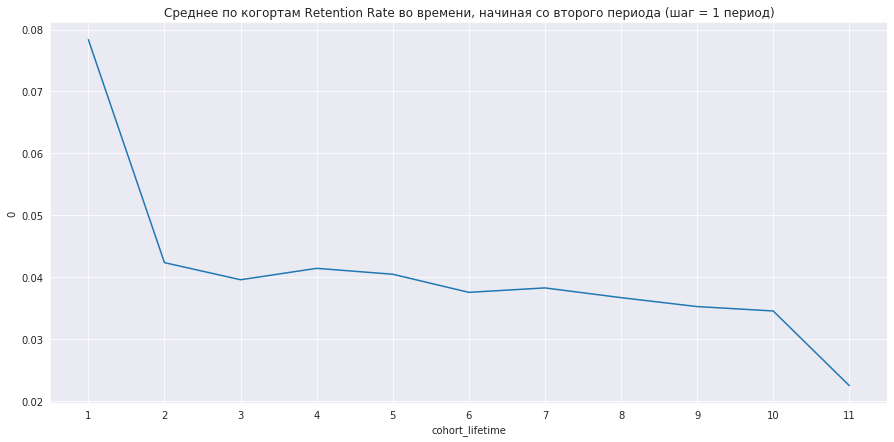

In [48]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=retention_pivot2.mean().reset_index(), x='cohort_lifetime', y=0)
plt.xticks(np.arange(1, 12, 1))
plt.title('Среднее по когортам Retention Rate во времени, начиная со второго периода (шаг = 1 период)')

Вывод: наблюдается резкое падение RR с 8% в первом периоде до 4% во 2 периоде.  Далее вплоть до 10 периода наблюдается очень медленное снижение RR до 3.5%.  на 11 периоде опять резкое падение до 2.2%

### Также для количественной оценки, которую укажем в финальном выводе посчитаем средний за месяц RR, рассчитанный в период со 2 по 7 месяц жизни когорты (индекс периода с 1 по 6,   берем только те когорты, у которых имеется данный период):

In [49]:
retention_pivot_6month = retention_pivot.loc['2017-06-01':'2017-11-01', 1:6]
retention_pivot_6month

cohort_lifetime,1,2,3,4,5,6
first_start_ts_month,,,,,,
2017-06-01,0.077683,0.051814,0.062901,0.067803,0.072404,0.061769
2017-07-01,0.077551,0.053438,0.056394,0.060750,0.049860,0.045348
2017-08-01,0.121859,0.063186,0.066879,0.052210,0.045133,0.041132
2017-09-01,0.084471,0.069504,0.050347,0.038733,0.040769,0.033645
2017-10-01,0.109202,0.053690,0.039040,0.038644,0.031834,0.022173
2017-11-01,0.077400,0.043343,0.041838,0.031745,0.024222,0.021066


In [50]:
np.nanmean(retention_pivot_6month)

0.054993903619985185

In [51]:
retention_pivot_6month.mean(axis=1).mean()

0.054993903619985185

# 2.2 Продажи

- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

## 2.2.1 Когда люди начинают покупать?

В качестве ответа на данный вопрос найдем разность между датой ПЕРВОГО посещения и датой ПЕРВОЙ покупки для каждого пользователя.  
## Разницу будем вычислять в днях

Создадим датафрейм с информацией о первом заказе для каждого пользователя

In [52]:
first_orders_visits = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders_visits.rename(columns = {'buy_ts':'first_buy_ts'}, inplace=True)
first_orders_visits.head(2)

,uid,first_buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00


Добавим в данный датафрейм инфомрацию о первой сессии пользователя (хранится в  ранее созданном датафрейме visits_first_start_ts)

In [53]:
visits_first_start_ts.head(2)

uid
11863502262781   2018-03-01 17:27:00
49537067089222   2018-02-06 15:55:00
Name: first_start_ts, dtype: datetime64[ns]

In [54]:
first_orders_visits = first_orders_visits.merge(
                visits_first_start_ts.reset_index()[['uid','first_start_ts']], on='uid', how='left')
first_orders_visits.head(2)

,uid,first_buy_ts,first_start_ts
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00


## Проверяем что, время заказа было позднее времени начала сессии:

In [55]:
first_orders_visits[first_orders_visits['first_buy_ts'] == first_orders_visits['first_start_ts']]

,uid,first_buy_ts,first_start_ts
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00
36,21801295586117262,2018-01-26 19:14:00,2018-01-26 19:14:00
77,40600246103358732,2017-07-21 19:08:00,2017-07-21 19:08:00
...,...,...,...
36446,18401744132870849367,2018-04-25 07:24:00,2018-04-25 07:24:00
36463,18411692028456746897,2018-01-31 19:30:00,2018-01-31 19:30:00
36477,18417037091353143232,2017-11-23 15:29:00,2017-11-23 15:29:00
36488,18422020045287977498,2017-12-30 21:32:00,2017-12-30 21:32:00


Есть много записей, где время старта = времени покупки. Странное явление. Не удаляем такие строки, но следует проконсультироваться с источником данных

In [56]:
first_orders_visits[first_orders_visits['first_buy_ts'] < first_orders_visits['first_start_ts']]

,uid,first_buy_ts,first_start_ts


По крайней мере нет случаев, когда покупка была раньше времени посещения

Вычисляем разность между временем покупки и временем посещения

In [57]:
first_orders_visits['time_before_buying'] = (first_orders_visits['first_buy_ts'] -
                                           first_orders_visits['first_start_ts'])
first_orders_visits.head(2)

,uid,first_buy_ts,first_start_ts,time_before_buying
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106 days 23:02:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00


Вычислим разницу "time_before_buying" в днях 

In [58]:
first_orders_visits['days_before_buying'] = first_orders_visits['time_before_buying'].dt.days
first_orders_visits.head(2)

,uid,first_buy_ts,first_start_ts,time_before_buying,days_before_buying
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106 days 23:02:00,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00,0


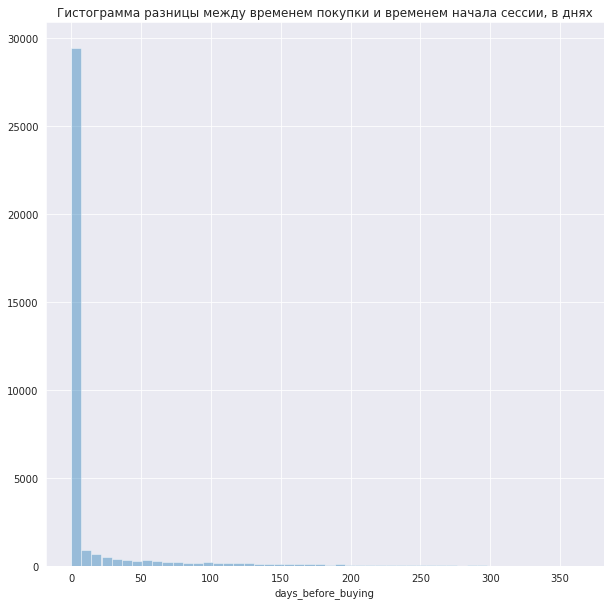

In [59]:
plt.figure(figsize=(10,10))
plt.title('Гистограмма разницы между временем покупки и временем начала сессии, в днях')
a = sns.distplot(first_orders_visits['days_before_buying'], kde=False)


In [60]:
print('Средняя разница между временем покупки и временем начала сессии, в днях:', first_orders_visits['days_before_buying'].mean())
print('Медиана разницы между временем покупки и временем начала сессии, в днях:', first_orders_visits['days_before_buying'].median())
print('Мода разницы между временем покупки и временем начала сессии, в днях:', first_orders_visits['days_before_buying'].mode())

Средняя разница между временем покупки и временем начала сессии, в днях: 16.7298688497659
Медиана разницы между временем покупки и временем начала сессии, в днях: 0.0
Мода разницы между временем покупки и временем начала сессии, в днях: 0    0
dtype: int64


Вывод: график имеет выбросы, поэтому целесообразно рассмтаривать в качестве метрики медианное значение. Таким образом в среднем покупки делаются в течение 1 дня (значение "0" на графике означает что разница < 1 дня)

## 2.2.2 Сколько раз покупают за период?

В качестве периода выберем 6 месяцев.  Разделим покупателей на когорты по месяцам. Возьмем только те когорты, по которым есть данные за 6 месяцев и выше. Рассчитаем число покупок за период для каждой отобранной когорты и найдем среднее

У нас есть информация о дате первого заказа в датафрейме first_orders_visits.   Перенесем эту информацию в orders

In [61]:
orders = orders.merge(first_orders_visits[['uid','first_buy_ts']], on='uid', how= 'left')

In [62]:
orders.head(2)

,buy_ts,revenue,uid,first_buy_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00


In [63]:
orders['first_buy_ts_month'] = orders['first_buy_ts'].astype('datetime64[M]')
orders.head(2)

,buy_ts,revenue,uid,first_buy_ts,first_buy_ts_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01


Вычисляем возраст каждой когорты

In [64]:
orders['cohort_lifetime'] = orders['buy_ts'] - orders['first_buy_ts']
orders['cohort_lifetime'] = orders['cohort_lifetime'] / np.timedelta64(1, 'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].astype('int')
orders.head(2)

,buy_ts,revenue,uid,first_buy_ts,first_buy_ts_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0


Создаем сводную таблицу количества покупок по когортам и возрасту когорты

In [65]:
orders_pivot = orders.pivot_table(index='first_buy_ts_month', columns = 'cohort_lifetime',
                   values='uid', aggfunc='count')
orders_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,2417.0,155.0,171.0,276.0,263.0,229.0,248.0,186.0,212.0,125.0,87.0,69.0
2017-07-01,2241.0,91.0,127.0,76.0,70.0,72.0,68.0,57.0,39.0,29.0,40.0,NaN
2017-08-01,1610.0,100.0,88.0,78.0,70.0,62.0,66.0,60.0,43.0,11.0,NaN,NaN
2017-09-01,3082.0,153.0,180.0,89.0,99.0,110.0,78.0,47.0,40.0,NaN,NaN,NaN
2017-10-01,5150.0,208.0,144.0,132.0,108.0,82.0,95.0,86.0,NaN,NaN,NaN,NaN
2017-11-01,5114.0,203.0,204.0,182.0,68.0,78.0,51.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,5184.0,236.0,207.0,117.0,93.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3944.0,172.0,87.0,76.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4244.0,114.0,79.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Берем срез периодов в 6 месяцев и находим среднее значение по когортам:

In [66]:
orders_pivot_slice = orders_pivot.loc['2017-06-01':'2017-12-01', 0:5]
orders_pivot_slice

cohort_lifetime,0,1,2,3,4,5
first_buy_ts_month,,,,,,
2017-06-01,2417.0,155.0,171.0,276.0,263.0,229.0
2017-07-01,2241.0,91.0,127.0,76.0,70.0,72.0
2017-08-01,1610.0,100.0,88.0,78.0,70.0,62.0
2017-09-01,3082.0,153.0,180.0,89.0,99.0,110.0
2017-10-01,5150.0,208.0,144.0,132.0,108.0,82.0
2017-11-01,5114.0,203.0,204.0,182.0,68.0,78.0
2017-12-01,5184.0,236.0,207.0,117.0,93.0,57.0


In [67]:
orders_pivot_slice.sum(axis=1).mean()

4210.857142857143

В среднем за период 6 месяцев каждая когорта совершает 4210.86 покупок 

## 2.2.3 Какой средний чек?

In [68]:
orders.head(2)

,buy_ts,revenue,uid,first_buy_ts,first_buy_ts_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0


Рассчитаем данную величину в лоб, найдя среднее значение чека по всем заказам:

In [69]:
orders['revenue'].mean()

4.999646930477041

Также покажем величину среднего чека по дням. Для этого надо сгруппировать заказы по дням

In [70]:
orders['buy_ts_day'] = orders['buy_ts'].astype('datetime64[D]')

In [71]:
df4 = orders.groupby('buy_ts_day')['revenue'].mean().reset_index()
df4.head(2)

,buy_ts_day,revenue
0,2017-06-01,4.056875
1,2017-06-02,2.919910


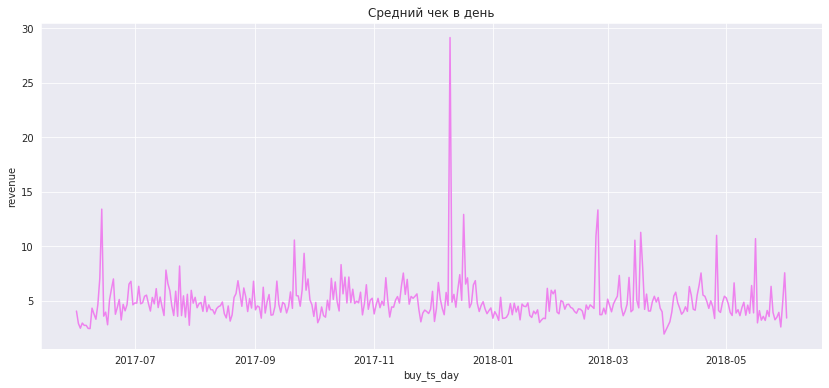

In [72]:
plt.figure(figsize=(14,6))
plt.title('Средний чек в день')
sns.lineplot(x = df4.buy_ts_day, y = df4.revenue, color='violet')

Наблюдается пиковое значение среднего чека. Выведем информацию о нем:

In [73]:
df4.sort_values('revenue', ascending=False).head(15)

,buy_ts_day,revenue
192,2017-12-10,29.133313
13,2017-06-14,13.403396
268,2018-02-24,13.328986
199,2017-12-17,12.916950
290,2018-03-18,11.273562
327,2018-04-26,10.998212
267,2018-02-23,10.921737
347,2018-05-16,10.697170
112,2017-09-21,10.568110
287,2018-03-15,10.553908


Вычисляем средний чек в день:

In [74]:
df4.revenue.mean()

4.936187581946566

Вывод: средний чек, вычисленный в лоб, как средний чек по каждой совершенной покупке равен 4.99 руб.  Средний чек, сгруппированный по дням, равен 4.93 руб. График изменения среднего чека во времени показывает, что средний чек в целом на одном уровне в течение всего рассмотренного интервала времени (но присутствует шум).  На 2017-12-10 приходится пиковое значение среднего чека = 29.13 руб

## 2.2.4 Сколько денег приносят? (LTV)

## LTV считается по валовой прибыли. Для вычисления валовой прибыли нужно знать маржинальность. Поскольку маржинальность не указана принимаем ее равной 1

In [75]:
MARGIN_RATE = 1

## Теперь можем вычислять LTV

Имеются данные за год. Удобнее всего считать LTV по когортам, сгруппированным по месяцам

In [76]:
orders['buy_ts_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head(2)

,buy_ts,revenue,uid,first_buy_ts,first_buy_ts_month,cohort_lifetime,buy_ts_day,buy_ts_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0,2017-06-01,2017-06-01


Получим месяцы первой покупки:

In [77]:
orders['first_buy_ts_month'] = orders['first_buy_ts'].astype('datetime64[M]')
orders.head(2)

,buy_ts,revenue,uid,first_buy_ts,first_buy_ts_month,cohort_lifetime,buy_ts_day,buy_ts_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0,2017-06-01,2017-06-01


Теперь можем посчитать количество покупателей за каждый месяц:

In [78]:
cohort_sizes = orders.groupby('first_buy_ts_month')['uid'].nunique().reset_index()
cohort_sizes.columns = ['first_buy_ts_month','n_buyers']
cohort_sizes.head(2)

,first_buy_ts_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. Сбросим индекс методом reset_index():

In [79]:
cohorts_orders = orders.groupby(['first_buy_ts_month','buy_ts_month']).agg({'revenue':'sum'}).reset_index()
cohorts_orders.head(2)

,first_buy_ts_month,buy_ts_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82


Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [80]:
report =pd.merge(cohort_sizes, cohorts_orders, on = 'first_buy_ts_month')

In [81]:
report

,first_buy_ts_month,n_buyers,buy_ts_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


Удаляем строку с месяцем 2018-06-01, т.к. там всего ода покупка

In [82]:
report = report.drop(index = 78)

Вычисляем валовую прибыль "gross_profit" и возраст когорты "age"

In [83]:
report['gross_profit'] = report['revenue'] * MARGIN_RATE
report['age'] = ((report['buy_ts_month'] - 
                  report['first_buy_ts_month']) / np.timedelta64(1,'M')).round().astype('int')
report.head(2)

,first_buy_ts_month,n_buyers,buy_ts_month,revenue,gross_profit,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1


Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте

In [84]:
report['ltv'] = report['gross_profit'] / report['n_buyers']
report.head(2)

,first_buy_ts_month,n_buyers,buy_ts_month,revenue,gross_profit,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329


Для наглядности визуализируем когорты в виде сводной таблицы:

In [85]:
output_ltv = report.pivot_table(
                        index = 'first_buy_ts_month',
                        columns = 'age', 
                        values = 'ltv',
                        aggfunc='mean')
output_ltv.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.02253,0.735502,0.95044,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.14182,0.161232,0.147145,0.155673,
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664,0.405007,0.292212,0.187978,,
2017-09-01,5.644529,1.11759,0.52093,3.97579,0.400558,0.647067,0.701608,0.24315,0.184006,,,
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.0848157,0.11547,,,,
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,,,,,
2017-12-01,4.738191,0.260374,0.925097,1.06527,0.31293,0.338047,,,,,,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.0626979,,,,,,,
2018-02-01,4.156987,0.278274,0.0785155,0.0741441,,,,,,,,


In [86]:
output_ltv.cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


_Рев 2. LTV следует считать за период. В качестве периода возьмем 6 месяцев (тогда в рассмотрении остается 7 когорт) и посчитаем средний LTV за этот период по когортам

Делаем срез: когорты с периодом 6 месяцев

In [87]:
output_ltv_6months = output_ltv.cumsum(axis=1).round(2).loc['2017-06-01':'2017-12-01', 0:5]
output_ltv_6months

age,0,1,2,3,4,5
first_buy_ts_month,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64


Вычисляем среднее LTV по когортам за 6 месяцев

In [88]:
round(output_ltv_6months[5].mean(),3)

7.97

## Дополнительно посчитаем CAC и ROMI:

Вычисляем суммарные расходы за каждый месяц:

In [89]:
costs.head(2)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25


In [90]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
costs.head(2)

,source_id,dt,costs,dt_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01


In [91]:
costs_month = costs.groupby('dt_month')['costs'].sum().reset_index()
costs_month.head(2)

,dt_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59


Добавим данные о расходах в отчёт и посчитаем CAC:

In [92]:
report_new = report.merge(costs_month, left_on='first_buy_ts_month', right_on='dt_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head(2)

,first_buy_ts_month,n_buyers,buy_ts_month,revenue,gross_profit,age,ltv,dt_month,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,2017-06-01,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,2017-06-01,18015.0,8.905091


Рассчитаем ROMI: поделим LTV на CAC.

In [93]:
report_new['romi'] = report_new['ltv'] / report_new['cac']

output_romi = report_new.pivot_table(
        index='first_buy_ts_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
output_romi.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,0.530530,0.0545001,0.0491446,0.107205,0.114825,0.0825934,0.10673,0.06531,0.0621232,0.0680272,0.0641499,0.0288437
2017-07-01,0.633623,0.0353393,0.0657353,0.0378447,0.0186381,0.0164512,0.0126728,0.0149513,0.0169978,0.0155127,0.0164117,
2017-08-01,0.488747,0.0437192,0.0424677,0.0362428,0.0457624,0.0262634,0.0195131,0.0375145,0.0270666,0.0174118,,
2017-09-01,0.597833,0.118368,0.0551736,0.421091,0.0424245,0.0685332,0.0743098,0.0257529,0.0194888,,,
2017-10-01,0.597866,0.064015,0.0228685,0.0187763,0.018109,0.0143813,0.0101341,0.0137968,,,,
2017-11-01,0.554931,0.0429797,0.0214834,0.034983,0.0159344,0.00580038,0.0123726,,,,,
2017-12-01,0.542015,0.0297849,0.105824,0.12186,0.0357969,0.0386701,,,,,,
2018-01-01,0.416173,0.0296618,0.0306201,0.0143679,0.00630935,,,,,,,
2018-02-01,0.463807,0.0310479,0.00876019,0.00827246,,,,,,,,


Покажем ROMI с накопительным эффектом:

In [94]:
output_romi.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


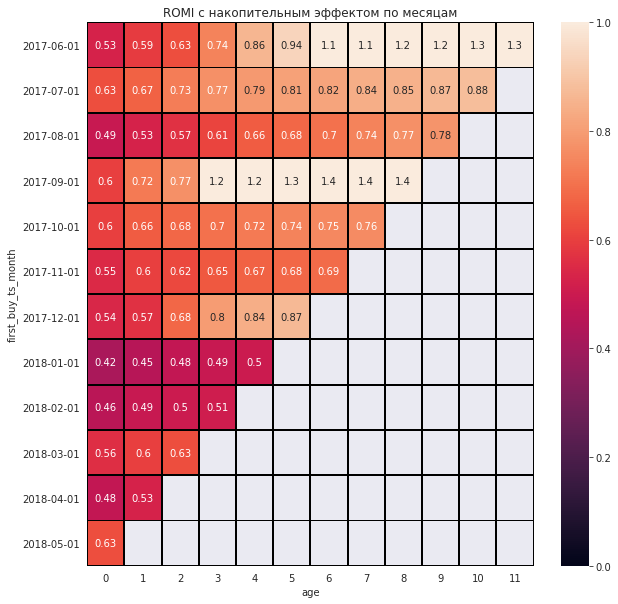

In [95]:
plt.figure(figsize=(10, 10))
plt.title('ROMI с накопительным эффектом по месяцам')
a = sns.heatmap(output_romi.cumsum(axis=1).round(2), annot=True, linewidths=1, linecolor='black',
               vmin = 0, vmax = 1.0, 
                yticklabels = df2.start_ts_month.apply(lambda x: x.date()));

По аналогии с LTV - ROMI следует считать за период. В качестве периода возьмем 6 месяцев (тогда в рассмотрении остается 7 когорт) и посчитаем средний ROMI за этот период по когортам

Делаем срез: когорты с периодом 6 месяцев

In [99]:
output_romi_6months = output_romi.cumsum(axis=1).round(2).loc['2017-06-01':'2017-12-01', 0:5]
output_romi_6months

age,0,1,2,3,4,5
first_buy_ts_month,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87


Вычисляем среднее ROMI по когортам за 6 месяцев

In [100]:
# В таблице уже накопительное, поэтому берем значение в последнем месяце
romi_6month_mean = round(output_romi_6months[5].mean(), 3)
romi_6month_mean

0.86

Вывод: средний ROMI по когортам за период 6 месяцев составил 86%. Т.е. за 6 месяцев в среднем когорты не окупаются. Возможно они окупятся за более долгий период, но для проверки необходимы данные за больший промежуток времени

# 2.3 Маркетинг

## 2.3.1 Сколько денег потратили? Всего / на каждый источник / по времени

#### Сколько денег потратили всего

In [101]:
costs['costs'].sum()

329131.62

Сколько денег потратили на каждый источник

In [102]:
costs_per_sources = costs.groupby('source_id')['costs'].sum().reset_index()
costs_per_sources

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


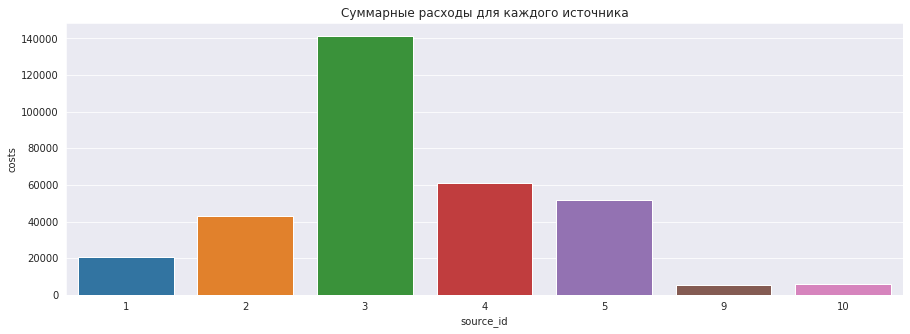

In [103]:
plt.figure(figsize=(15,5))
plt.title('Суммарные расходы для каждого источника')
sns.barplot(data=costs_per_sources, x='source_id', y='costs')

#### Сколько денег потратили по времени

Рассмотрим траты по дням:

In [104]:
costs['dt_days'] = costs['dt'].astype('datetime64[D]')

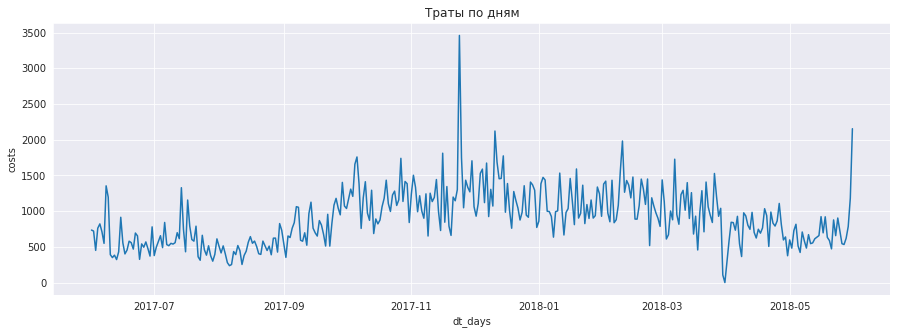

In [105]:
plt.figure(figsize=(15,5))
plt.title('Траты по дням')
sns.lineplot(data=costs.groupby('dt_days')['costs'].sum().reset_index(), x='dt_days', y='costs')

Средние траты в сутки:

In [106]:
costs.groupby('dt_days')['costs'].sum().reset_index()['costs'].mean()

904.2077472527473

Вывод: Самые большие траты у источника 3, самые низкие у 9-ого и 10-ого.  Траты по дням в целом ниже в период весна/лето и выше в период осень/зима.

## 2.3.2 Сколько стоило привлечение одного покупателя из каждого источника? (CAC)

В процессе выполнения проекта обнаружили ошибку: в датафрейме visits есть 2 записи для одного и того же юзера с одинаковым временем старта сессии, соответствующему ПЕРВОМУ посещению.  Это вызовет ошибку - дублирование записей при использовании merge / join.  Поэтому удалим лишнюю запись (ту, в которой совпадает время старта и окончания сессии)

In [107]:
visits[visits['uid'] == 1981020429381477763]

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month,duration_ts,duration_ts_seconds,first_start_ts,first_start_ts_month,cohort_lifetime
44993,touch,2018-03-16 08:57:00,1,2018-03-16 08:55:00,1981020429381477763,2018-03-16,2018-03-12,2018-03-01,00:02:00,120.0,2018-03-16 08:55:00,2018-03-01,0
47067,touch,2018-03-16 08:55:00,1,2018-03-16 08:55:00,1981020429381477763,2018-03-16,2018-03-12,2018-03-01,00:00:00,0.0,2018-03-16 08:55:00,2018-03-01,0


In [108]:
visits = visits.drop(index=47067)

Лишняя строка удалена, можем продолжать

Чтобы ответить на вопрос данного пункта, нужно определить - к какому источнику относится каждый юзер.  Принимаем, что каждый юзер соответствует источнику, с которого он в первый раз посетил наше приложение 

Отфильтруем датафрейм visits - оставим в нем только записи с первым посещением:

In [109]:
visits_first_source_id = visits[visits['start_ts'] == visits['first_start_ts']]
visits_first_source_id.head(2)

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month,duration_ts,duration_ts_seconds,first_start_ts,first_start_ts_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,00:18:00,1080.0,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,00:28:00,1680.0,2018-02-19 16:53:00,2018-02-01,0


In [110]:
visits_first_source_id

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month,duration_ts,duration_ts_seconds,first_start_ts,first_start_ts_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,00:18:00,1080.0,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,00:28:00,1680.0,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01,00:00:00,0.0,2017-07-01 01:54:00,2017-07-01,0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01,00:00:00,0.0,2017-12-27 14:06:00,2017-12-01,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-08-28,2017-09-01,00:01:00,60.0,2017-09-03 21:35:00,2017-09-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-07-24,2017-07-01,00:00:19,19.0,2017-07-29 19:07:00,2017-07-01,0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-22,2018-01-01,00:00:19,19.0,2018-01-25 17:38:00,2018-01-01,0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-02-26,2018-03-01,00:00:19,19.0,2018-03-03 10:12:00,2018-03-01,0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-10-30,2017-11-01,00:00:19,19.0,2017-11-02 10:12:00,2017-11-01,0


Теперь из отфильтованного датафрейма visits можем перенести информацию об источнике в датафрейм orders

In [111]:
orders = orders.merge(visits_first_source_id[['uid','source_id']], on ='uid', how='left')

In [112]:
orders.head(2)

,buy_ts,revenue,uid,first_buy_ts,first_buy_ts_month,cohort_lifetime,buy_ts_day,buy_ts_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0,2017-06-01,2017-06-01,2


Вычислим количество пользователей, привлеченных из каждого источника:

In [113]:
users_per_sources = orders.groupby('source_id').agg({'uid': 'nunique'}).reset_index()
users_per_sources.columns = ['source_id', 'n_users']
users_per_sources

,source_id,n_users
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [114]:
costs_per_sources

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [115]:
users_per_sources = users_per_sources.merge(costs_per_sources, on='source_id', how='outer')

In [116]:
users_per_sources

,source_id,n_users,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10296,61073.60
4,5,6931,51757.10
5,7,1,NaN
6,9,1088,5517.49
7,10,1329,5822.49


Удалим источник 7, т.к. в нем всего 1 пользователь и расходов на него не было

In [117]:
users_per_sources.drop(index=5, inplace=True)

In [118]:
users_per_sources = users_per_sources.reset_index().drop(columns = 'index')
users_per_sources

,source_id,n_users,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10296,61073.60
4,5,6931,51757.10
5,9,1088,5517.49
6,10,1329,5822.49


Вычисляем CAC

In [119]:
users_per_sources['cac'] = users_per_sources['costs'] / users_per_sources['n_users']
users_per_sources

,source_id,n_users,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,9,1088,5517.49,5.071222
6,10,1329,5822.49,4.381106


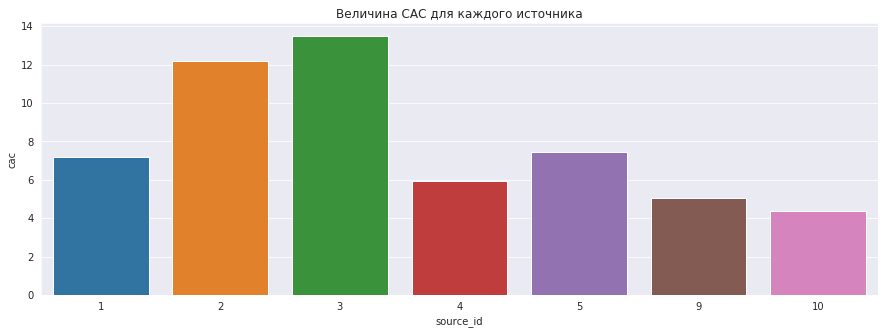

In [120]:
plt.figure(figsize=(15,5))
plt.title('Величина CAC для каждого источника')
sns.barplot(data=users_per_sources, x = 'source_id',y = 'cac')

Самый высокий СAC у источников 2,3. Самый низкий - у 4,9,10

## 2.3.3 На сколько окупились расходы? (ROI)

ROI будем вычислять для каждого источника, как отношение LTV к CAC.   Информация по CAC у нас есть.  Вычислим LTV

In [121]:
users_per_sources

,source_id,n_users,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,9,1088,5517.49,5.071222
6,10,1329,5822.49,4.381106


In [122]:
revenue_per_sources = orders.groupby('source_id')['revenue'].sum().reset_index()
revenue_per_sources.columns = ['source_id', 'revenue_per_source']
revenue_per_sources

,source_id,revenue_per_source
0,1,31090.55
1,2,46923.61
2,3,54511.24
3,4,56696.83
4,5,52624.02
5,7,1.22
6,9,5759.40
7,10,4450.33


In [123]:
users_per_sources = users_per_sources.merge(revenue_per_sources, on='source_id', how='left')
users_per_sources

,source_id,n_users,costs,cac,revenue_per_source
0,1,2899,20833.27,7.186364,31090.55
1,2,3506,42806.04,12.209367,46923.61
2,3,10473,141321.63,13.493901,54511.24
3,4,10296,61073.60,5.931779,56696.83
4,5,6931,51757.10,7.467479,52624.02
5,9,1088,5517.49,5.071222,5759.40
6,10,1329,5822.49,4.381106,4450.33


In [124]:
users_per_sources['ltv'] = users_per_sources['revenue_per_source'] / users_per_sources['n_users']
users_per_sources['roi'] = users_per_sources['ltv'] / users_per_sources['cac']
users_per_sources

,source_id,n_users,costs,cac,revenue_per_source,ltv,roi
0,1,2899,20833.27,7.186364,31090.55,10.724577,1.492351
1,2,3506,42806.04,12.209367,46923.61,13.383802,1.096191
2,3,10473,141321.63,13.493901,54511.24,5.204931,0.385725
3,4,10296,61073.60,5.931779,56696.83,5.506685,0.928336
4,5,6931,51757.10,7.467479,52624.02,7.592558,1.016750
5,9,1088,5517.49,5.071222,5759.40,5.293566,1.043844
6,10,1329,5822.49,4.381106,4450.33,3.348631,0.764335


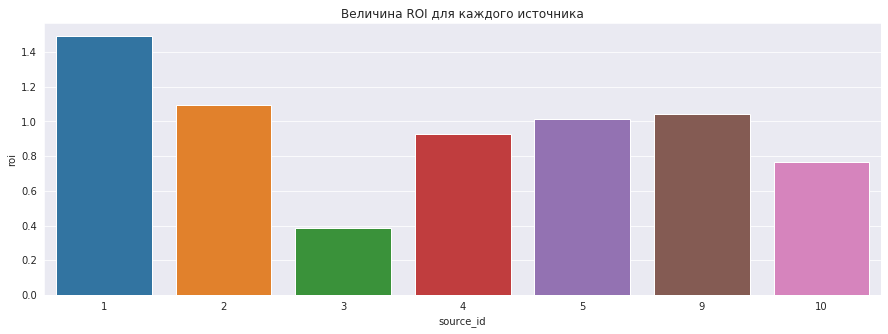

In [125]:
plt.figure(figsize=(15,5))
plt.title('Величина ROI для каждого источника')
sns.barplot(data=users_per_sources, x = 'source_id',y = 'roi')

Доля расходов на источник 3 от всех расходов:

In [126]:
users_per_sources.loc[2,'costs'] / users_per_sources.sum()['costs']

0.4293772503535212

Вывод:
1. Окупились и принесли прибыль следующие источники (roi > 1):  1,2,5,9.  (Источник 9 - работает почти в ноль,  прибыль - 1.6%)
2. Неокупились источники (roi < 1):  3, 4, 10.
3. Отдельно стоит отметить источник 3, у которого самый низкий ROI = 0.386 при самых высоких расходах 131322 руб (43% от общих расходов).  Стоит задуматься о целесообразности вложения денег в этот источник

## 2.3.4 Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

# Графики по устройствам строим для метрик до  пункта 2.2.4 (LTV). Графики по рекламным источникам строим для метрик после пункта 2.2.4 (LTV) 

### 2.3.4.1 Сколько людей пользуются в день, неделю, месяц?

In [127]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

## День

In [128]:
visits_device_day = visits.groupby(['device', 'start_ts_day']).agg({'uid': 'count'}).reset_index()

Text(0.5, 1.0, 'Количество посетителей в день в зависимости от устройства')

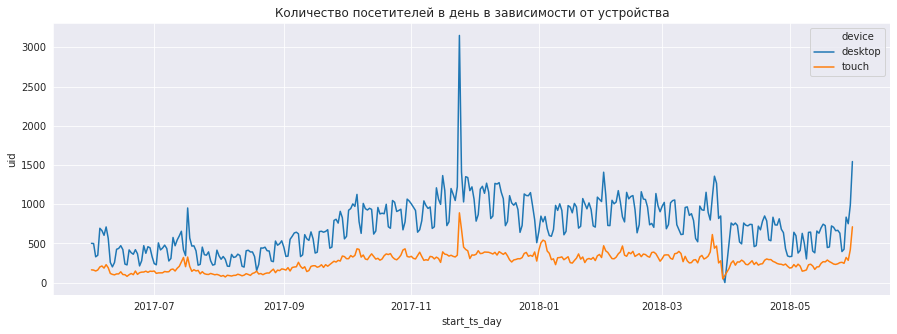

In [129]:
plt.figure(figsize=(15,5))
a = sns.lineplot(data=visits_device_day, x='start_ts_day', y='uid', hue = 'device')
a.set_title('Количество посетителей в день в зависимости от устройства')

Также покажем средние значения для каждого устройства:

In [130]:
df5 = visits_device_day.groupby(['device'])['uid'].mean()
df5

device
desktop    721.337912
touch      266.754821
Name: uid, dtype: float64

## Неделя

In [131]:
visits_device_week = visits.groupby(['device', 'start_ts_week']).agg({'uid': 'count'}).reset_index()

Text(0.5, 1.0, 'Количество посетителей в неделю в зависимости от устройства')

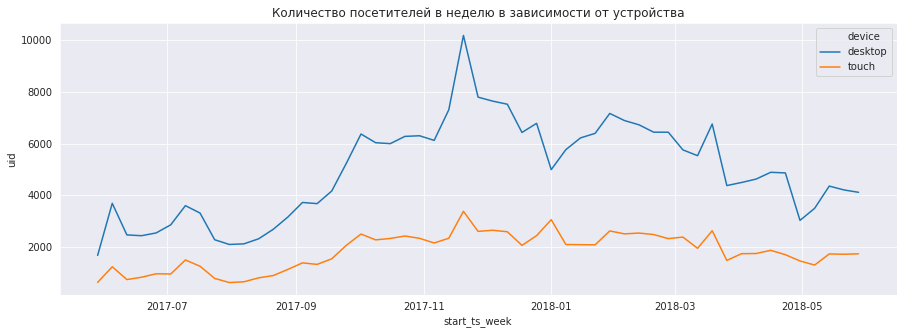

In [132]:
plt.figure(figsize=(15,5))
a = sns.lineplot(data=visits_device_week, x='start_ts_week', y='uid', hue = 'device')
a.set_title('Количество посетителей в неделю в зависимости от устройства')

Также покажем средние значения для каждого устройства:

In [133]:
df6 = visits_device_week.groupby(['device'])['uid'].mean()
df6

device
desktop    4954.094340
touch      1827.018868
Name: uid, dtype: float64

## Год

In [134]:
visits_device_month = visits.groupby(['device', 'start_ts_month']).agg({'uid': 'count'}).reset_index()

Text(0.5, 1.0, 'Количество посетителей в месяц в зависимости от устройства')

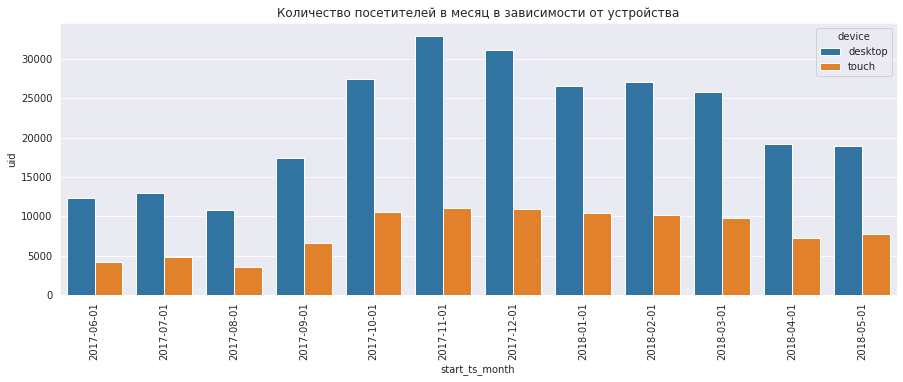

In [135]:
plt.figure(figsize=(15,5))
a = sns.barplot(data=visits_device_month, x='start_ts_month', y='uid', hue='device')
a.set_xticklabels(df2.start_ts_month.apply(lambda x: x.date()),rotation=90)
a.set_title('Количество посетителей в месяц в зависимости от устройства')

Также покажем средние значения для каждого устройства:

In [136]:
df7 = visits_device_month.groupby(['device'])['uid'].mean()
df7

device
desktop    21880.583333
touch       8069.333333
Name: uid, dtype: float64

### 2.3.4.2 Сколько сессий в день?

In [137]:
n_sessions_day = visits.groupby(['device', 'start_ts_day'])['uid'].count().reset_index()
n_sessions_day.rename(columns={'uid':'n_sessions'}, inplace=True)
n_sessions_day.head(2)

,device,start_ts_day,n_sessions
0,desktop,2017-06-01,501
1,desktop,2017-06-02,498


In [138]:
n_users_day = visits.groupby(['device', 'start_ts_day'])['uid'].nunique().reset_index()
n_users_day.rename(columns={'uid':'n_users'}, inplace=True)
n_users_day.head(2)

,device,start_ts_day,n_users
0,desktop,2017-06-01,455
1,desktop,2017-06-02,458


In [139]:
n_users_sessions = pd.concat([n_sessions_day, n_users_day['n_users']], axis=1)
n_users_sessions['session_per_users'] = n_users_sessions['n_sessions'] / n_users_sessions['n_users']
n_users_sessions.head(2)

,device,start_ts_day,n_sessions,n_users,session_per_users
0,desktop,2017-06-01,501,455,1.101099
1,desktop,2017-06-02,498,458,1.087336


Text(0.5, 1.0, 'Количество сессий в день в зависимости от устройства')

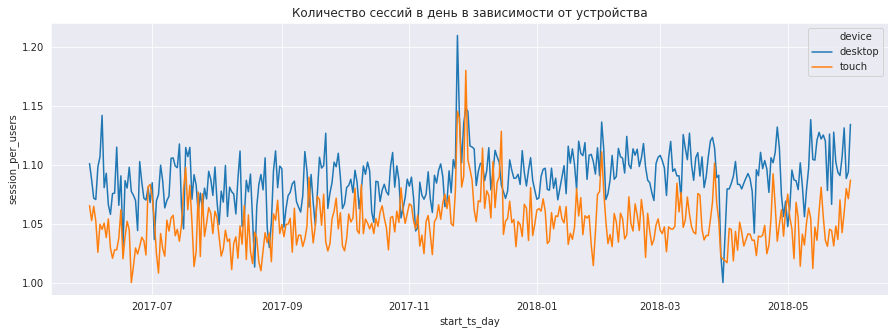

In [140]:
plt.figure(figsize=(15,5))
a = sns.lineplot(data=n_users_sessions, x='start_ts_day', y='session_per_users', hue = 'device')
a.set_title('Количество сессий в день в зависимости от устройства')

Также покажем средние значения для каждого устройства:

In [141]:
df8 = n_users_sessions.groupby(['device'])['session_per_users'].mean()
df8

device
desktop    1.088955
touch      1.051062
Name: session_per_users, dtype: float64

### 2.3.4.3 Сколько длится одна сессия?

In [142]:
session_duration = visits.groupby(
    ['start_ts_day','device'])['duration_ts_seconds'].mean().reset_index()
session_duration.head(2)

,start_ts_day,device,duration_ts_seconds
0,2017-06-01,desktop,724.267465
1,2017-06-01,touch,488.214724


Text(0.5, 1.0, 'Средняя продолжительность сессий в день в зависимости от устройства, сек')

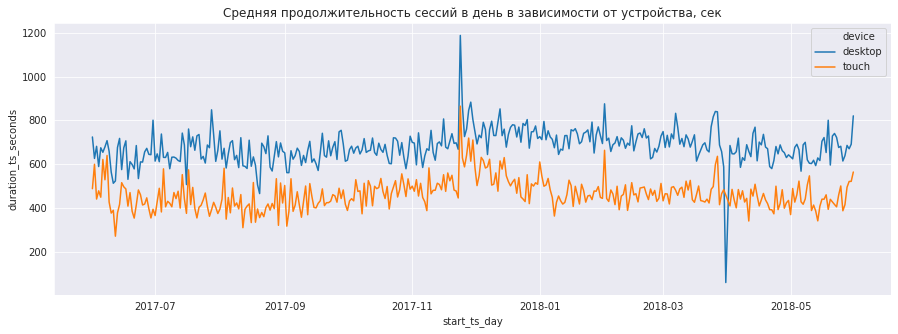

In [143]:
plt.figure(figsize=(15,5))
a = sns.lineplot(data=session_duration, x='start_ts_day', y='duration_ts_seconds', hue = 'device')
a.set_title('Средняя продолжительность сессий в день в зависимости от устройства, сек')

Также покажем средние значения для каждого устройства:

In [144]:
df9 = session_duration.groupby(['device'])['duration_ts_seconds'].mean()
df9

device
desktop    681.074205
touch      463.671291
Name: duration_ts_seconds, dtype: float64

### 2.3.4.4 Как часто люди возвращаются?

Тут повторяем вычисления retention rate, только разделяем сессии по типу устройств. Таким образом в результате получится 2 тепловые карты

### !!! Очень важный момент.  Для работы мы используем таблицу visits. В ней есть записи для одного и того же юзера,  но заходившего с разных устройств. В этом случае при группировке по типу устройств один и тот же юзер может попасть в обе группы, т.к. заходил с обоих устройств.   Чтобы этого избежать, создадим в таблице visits столбец с типом устройства, но в нем будет тот тип устройства, с которого в первый раз зашел юзер (по этому принципу мы и делили юзеров) и будем группироваться по этому столбцу

У нас уже есть таблица visits_first_source_id -  это отфильтрованная таблица visits, в которой есть только записи ПЕРВЫХ посещений.  Значит из нее можем взять значения device и перенести их в исходную таблицу vivsits

In [145]:
visits_first_source_id['device_first'] = visits_first_source_id['device']
visits_first_source_id.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month,duration_ts,duration_ts_seconds,first_start_ts,first_start_ts_month,cohort_lifetime,device_first
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,00:18:00,1080.0,2017-12-20 17:20:00,2017-12-01,0,touch
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,00:28:00,1680.0,2018-02-19 16:53:00,2018-02-01,0,desktop


In [146]:
visits = visits.merge(visits_first_source_id[['uid','device_first']], on='uid', how='left')

### Теперь можем без проблем делать группировку по устойствам, но используем столбец 'device_first'

In [147]:
visits.head(2)

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month,duration_ts,duration_ts_seconds,first_start_ts,first_start_ts_month,cohort_lifetime,device_first
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,00:18:00,1080.0,2017-12-20 17:20:00,2017-12-01,0,touch
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,00:28:00,1680.0,2018-02-19 16:53:00,2018-02-01,0,desktop


In [148]:
cohorts_visits_device = visits.groupby(
    ['device_first','first_start_ts_month','cohort_lifetime'])['uid'].nunique().reset_index()
cohorts_visits_device.rename(columns={'uid':'n_users'}, inplace=True)
cohorts_visits_device.head(2)

,device_first,first_start_ts_month,cohort_lifetime,n_users
0,desktop,2017-06-01,0,9675
1,desktop,2017-06-01,1,789


In [149]:
initial_users_count_device = cohorts_visits_device.query(
    'cohort_lifetime == 0')[['device_first','first_start_ts_month','n_users']]
initial_users_count_device.rename(columns={'n_users':'cohort_users'}, inplace=True)
initial_users_count_device.head(2)

,device_first,first_start_ts_month,cohort_users
0,desktop,2017-06-01,9675
12,desktop,2017-07-01,8997


In [150]:
cohorts_visits_device = cohorts_visits_device.merge(
    initial_users_count_device, on = ['device_first','first_start_ts_month'], how = 'left')

In [151]:
cohorts_visits_device.query(
    'first_start_ts_month == "2018-05-01" & cohort_lifetime == 0')

,device_first,first_start_ts_month,cohort_lifetime,n_users,cohort_users
80,desktop,2018-05-01,0,9444,9444
162,touch,2018-05-01,0,4763,4763


In [152]:
cohorts_visits_device.query(
    'first_start_ts_month == "2018-05-01" & cohort_lifetime == 0')['cohort_users'].sum()

14207

In [153]:
cohorts_visits_device['retention_rate'] = cohorts_visits_device['n_users']  /        \
                                             cohorts_visits_device['cohort_users']
cohorts_visits_device

,device_first,first_start_ts_month,cohort_lifetime,n_users,cohort_users,retention_rate
0,desktop,2017-06-01,0,9675,9675,1.000000
1,desktop,2017-06-01,1,789,9675,0.081550
2,desktop,2017-06-01,2,541,9675,0.055917
3,desktop,2017-06-01,3,663,9675,0.068527
4,desktop,2017-06-01,4,702,9675,0.072558
...,...,...,...,...,...,...
159,touch,2018-04-01,0,4935,4935,1.000000
160,touch,2018-04-01,1,200,4935,0.040527
161,touch,2018-04-01,2,1,4935,0.000203
162,touch,2018-05-01,0,4763,4763,1.000000


Далее формируем сводные таблицы, по которым будем строить тепловые карты.  Тут уже берем не всю таблицу, а делаем срез по типу устройства

In [154]:
retention_pivot_desktop = cohorts_visits_device.query(
    'device_first == "desktop"').pivot_table(index = 'first_start_ts_month', columns = 'cohort_lifetime',
                                     values = 'retention_rate')
#retention_pivot_desktop.fillna('', inplace=True)
retention_pivot_desktop

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_start_ts_month,,,,,,,,,,,,
2017-06-01,1.0,0.081550,0.055917,0.068527,0.072558,0.079276,0.067597,0.061602,0.061292,0.054470,0.045271,0.048475
2017-07-01,1.0,0.084473,0.056574,0.061243,0.065244,0.054018,0.049461,0.053796,0.042347,0.032678,0.029343,0.000667
2017-08-01,1.0,0.124436,0.065107,0.070885,0.057215,0.045800,0.042418,0.041150,0.033681,0.030017,NaN,NaN
2017-09-01,1.0,0.085604,0.074602,0.054061,0.040052,0.044091,0.036356,0.026816,0.023807,NaN,NaN,NaN
2017-10-01,1.0,0.115943,0.056305,0.041396,0.041622,0.034506,0.024341,0.023381,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.077089,0.043965,0.042811,0.033024,0.025997,0.021882,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.067213,0.042465,0.031226,0.021592,0.020651,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.099670,0.038391,0.028166,0.022559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.052758,0.027641,0.019938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


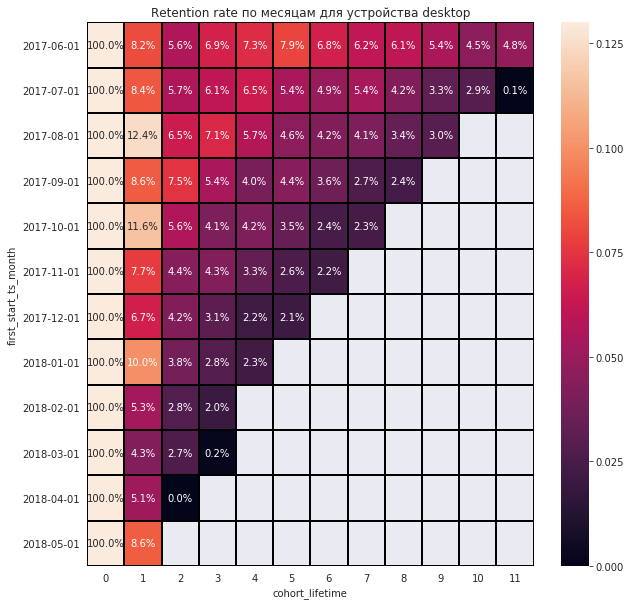

In [155]:
plt.figure(figsize=(10, 10))
plt.title('Retention rate по месяцам для устройства desktop')
a = sns.heatmap(retention_pivot_desktop, annot=True, fmt='.1%', linewidths=1, linecolor='black',
               vmin = 0, vmax = 0.13, 
               yticklabels = df2.start_ts_month.apply(lambda x: x.date()));

In [156]:
retention_pivot_touch = cohorts_visits_device.query(
    'device_first == "touch"').pivot_table(index = 'first_start_ts_month', columns = 'cohort_lifetime',
                                     values = 'retention_rate')
#retention_pivot_desktop.fillna('', inplace=True)
retention_pivot_touch

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_start_ts_month,,,,,,,,,,,,
2017-06-01,1.0,0.067243,0.040737,0.047712,0.054967,0.053850,0.046038,0.040458,0.040179,0.037109,0.030413,0.033203
2017-07-01,1.0,0.061415,0.046126,0.045089,0.050272,0.040166,0.035761,0.041980,0.032133,0.021508,0.024100,0.000259
2017-08-01,1.0,0.114964,0.058047,0.056163,0.038824,0.043347,0.037693,0.035055,0.018847,0.017339,NaN,NaN
2017-09-01,1.0,0.081870,0.057802,0.041823,0.035707,0.033143,0.027422,0.020122,0.018347,NaN,NaN,NaN
2017-10-01,1.0,0.093390,0.047556,0.033514,0.031660,0.025566,0.017088,0.014704,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078247,0.041650,0.039192,0.028267,0.019391,0.018845,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.080938,0.038270,0.028886,0.019355,0.014370,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.084304,0.035667,0.021665,0.015475,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.045192,0.021485,0.018373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


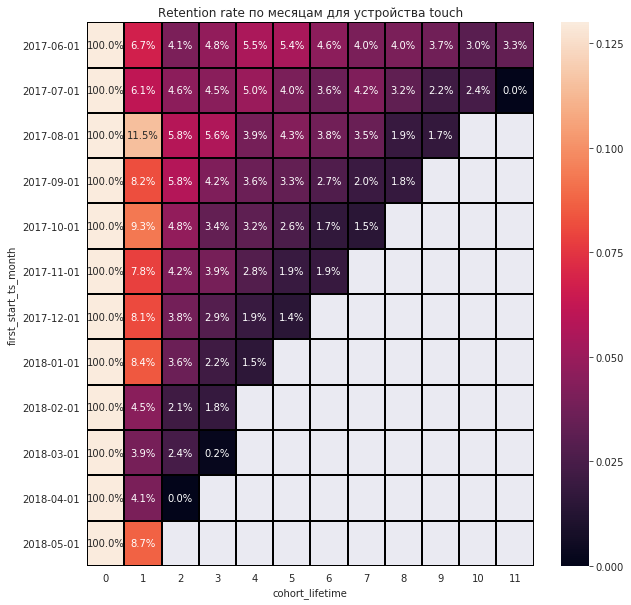

In [157]:
plt.figure(figsize=(10, 10))
plt.title('Retention rate по месяцам для устройства touch')
a = sns.heatmap(retention_pivot_touch, annot=True, fmt='.1%', linewidths=1, linecolor='black',
               vmin = 0, vmax = 0.13, 
               yticklabels = df2.start_ts_month.apply(lambda x: x.date()));

### Также для количественной оценки, которую укажем в финальном выводе посчитаем средний за месяц RR, рассчитанный в период со 2 по 7 месяц жизни когорты (индекс периода с 1 по 6,   берем только те когорты, у которых имеется данный период):  

In [158]:
retention_pivot_desktop_6month = retention_pivot_desktop.loc['2017-06-01':'2017-11-01', 1:6]
retention_pivot_touch_6month = retention_pivot_touch.loc['2017-06-01':'2017-11-01', 1:6]

display(retention_pivot_desktop_6month)
display(retention_pivot_touch_6month)

cohort_lifetime,1,2,3,4,5,6
first_start_ts_month,,,,,,
2017-06-01,0.081550,0.055917,0.068527,0.072558,0.079276,0.067597
2017-07-01,0.084473,0.056574,0.061243,0.065244,0.054018,0.049461
2017-08-01,0.124436,0.065107,0.070885,0.057215,0.045800,0.042418
2017-09-01,0.085604,0.074602,0.054061,0.040052,0.044091,0.036356
2017-10-01,0.115943,0.056305,0.041396,0.041622,0.034506,0.024341
2017-11-01,0.077089,0.043965,0.042811,0.033024,0.025997,0.021882


cohort_lifetime,1,2,3,4,5,6
first_start_ts_month,,,,,,
2017-06-01,0.067243,0.040737,0.047712,0.054967,0.053850,0.046038
2017-07-01,0.061415,0.046126,0.045089,0.050272,0.040166,0.035761
2017-08-01,0.114964,0.058047,0.056163,0.038824,0.043347,0.037693
2017-09-01,0.081870,0.057802,0.041823,0.035707,0.033143,0.027422
2017-10-01,0.093390,0.047556,0.033514,0.031660,0.025566,0.017088
2017-11-01,0.078247,0.041650,0.039192,0.028267,0.019391,0.018845


In [159]:
round(np.nanmean(retention_pivot_desktop_6month),3)

0.058

In [160]:
round(np.nanmean(retention_pivot_touch_6month),3)

0.047

Вывод: судя по тепловым картам (визуально видно), и по вычесленным средним RR за месяц пользователи категории "desktop" имеют более высокий "retention rate", чем пользователи категории "touch"

### 2.3.4.5 Когда люди начинают покупать?

Отфильтруем таблицу visits, оставив в ней только записи с первыми сессиями

In [161]:
visits_firsts = visits[visits['start_ts'] == visits['first_start_ts']]
visits_firsts.head(2)

,device,end_ts,source_id,start_ts,uid,start_ts_day,start_ts_week,start_ts_month,duration_ts,duration_ts_seconds,first_start_ts,first_start_ts_month,cohort_lifetime,device_first
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,00:18:00,1080.0,2017-12-20 17:20:00,2017-12-01,0,touch
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,00:28:00,1680.0,2018-02-19 16:53:00,2018-02-01,0,desktop


Добавим в ранее созданную таблицу first_orders_visits информацию об устройствах из созданной выше таблицы visits_firsts

In [162]:
first_orders_visits = first_orders_visits.merge(visits_firsts[['uid','device']], on='uid', how='left')

In [163]:
first_orders_visits.head(2)

,uid,first_buy_ts,first_start_ts,time_before_buying,days_before_buying,device
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106 days 23:02:00,106,desktop
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00,0,touch


Строим гистограмму и считаем метрики для устройства touch

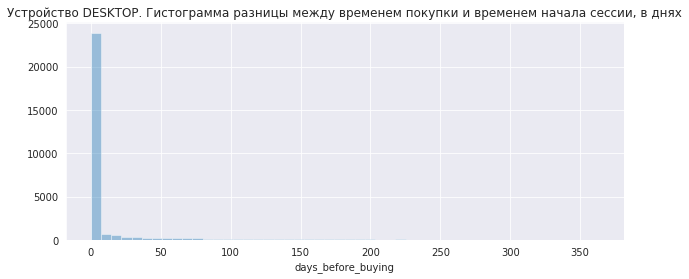

In [164]:
plt.figure(figsize=(10,4))
plt.title('Устройство DESKTOP. Гистограмма разницы между временем покупки и временем начала сессии, в днях')
a = sns.distplot(first_orders_visits.query('device == "desktop"')['days_before_buying'], kde=False)

In [165]:
print('mean=', first_orders_visits.query('device == "desktop"')['days_before_buying'].mean())
print('median=', first_orders_visits.query('device == "desktop"')['days_before_buying'].median())
print('mode=', first_orders_visits.query('device == "desktop"')['days_before_buying'].mode())

mean= 15.84855020369039
median= 0.0
mode= 0    0
dtype: int64


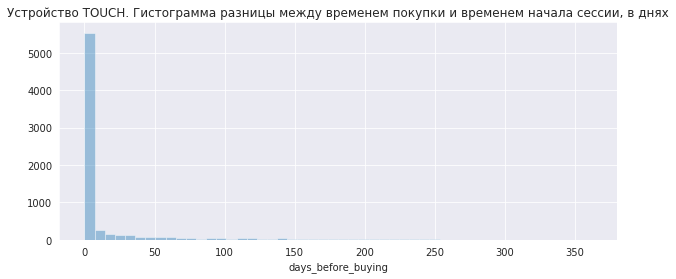

In [166]:
plt.figure(figsize=(10,4))
plt.title('Устройство TOUCH. Гистограмма разницы между временем покупки и временем начала сессии, в днях')
a = sns.distplot(first_orders_visits.query('device == "touch"')['days_before_buying'], kde=False)

In [167]:
print('mean=', first_orders_visits.query('device == "touch"')['days_before_buying'].mean())
print('median=', first_orders_visits.query('device == "touch"')['days_before_buying'].median())
print('mode=', first_orders_visits.query('device == "touch"')['days_before_buying'].mode())

mean= 20.250683807439824
median= 0.0
mode= 0    0
dtype: int64


Вывод: для обоих типов устройств заказ в среднем происходит в тот же день, когда было первое посещение (на гистограммах значение "0" - соответсвует тому, что время до покупки заняло менее 1 дня)

### 2.3.4.6 Сколько раз покупают за период?

Методика полностью соответствует аналогичному пункту выше. Только теперь считаем отдельно по устройствам. Рассматриваемый период = 6 месяцев

Добавим в таблицу orders информацию об устройстве из visits_firsts

In [168]:
orders = orders.merge(visits_firsts[['uid','device']], on='uid', how='left')

In [169]:
orders.head(2)

,buy_ts,revenue,uid,first_buy_ts,first_buy_ts_month,cohort_lifetime,buy_ts_day,buy_ts_month,source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0,2017-06-01,2017-06-01,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0,2017-06-01,2017-06-01,2,desktop


## Вычислим искомую величину для устройства touch

In [170]:
orders_pivot_touch = orders.query('device == "touch"').pivot_table(
    index='first_buy_ts_month', columns = 'cohort_lifetime', values='uid', aggfunc='count')
orders_pivot_touch

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,365.0,10.0,1.0,12.0,12.0,4.0,2.0,3.0,4.0,10.0,1.0,7.0
2017-07-01,470.0,16.0,21.0,16.0,13.0,7.0,11.0,14.0,10.0,9.0,5.0,NaN
2017-08-01,298.0,15.0,11.0,4.0,3.0,14.0,7.0,3.0,7.0,2.0,NaN,NaN
2017-09-01,656.0,37.0,36.0,11.0,10.0,23.0,7.0,7.0,4.0,NaN,NaN,NaN
2017-10-01,974.0,41.0,29.0,18.0,12.0,11.0,14.0,8.0,NaN,NaN,NaN,NaN
2017-11-01,966.0,32.0,18.0,29.0,7.0,12.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,1058.0,33.0,15.0,12.0,11.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,807.0,12.0,10.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,999.0,15.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
orders_pivot_touch_slice = orders_pivot_touch.loc['2017-06-01':'2017-12-01', 0:5]
orders_pivot_touch_slice

cohort_lifetime,0,1,2,3,4,5
first_buy_ts_month,,,,,,
2017-06-01,365.0,10.0,1.0,12.0,12.0,4.0
2017-07-01,470.0,16.0,21.0,16.0,13.0,7.0
2017-08-01,298.0,15.0,11.0,4.0,3.0,14.0
2017-09-01,656.0,37.0,36.0,11.0,10.0,23.0
2017-10-01,974.0,41.0,29.0,18.0,12.0,11.0
2017-11-01,966.0,32.0,18.0,29.0,7.0,12.0
2017-12-01,1058.0,33.0,15.0,12.0,11.0,4.0


In [172]:
orders_pivot_touch_slice.sum(axis=1)

first_buy_ts_month
2017-06-01     404.0
2017-07-01     543.0
2017-08-01     345.0
2017-09-01     773.0
2017-10-01    1085.0
2017-11-01    1064.0
2017-12-01    1133.0
dtype: float64

In [173]:
orders_pivot_touch_slice.sum(axis=1).mean()

763.8571428571429

## Вычислим искомую величину для устройства desktop

In [174]:
orders_pivot_desktop = orders.query('device == "desktop"').pivot_table(
    index='first_buy_ts_month', columns = 'cohort_lifetime', values='uid', aggfunc='count')
orders_pivot_desktop

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,2052.0,145.0,170.0,264.0,251.0,225.0,246.0,183.0,208.0,115.0,86.0,62.0
2017-07-01,1771.0,75.0,106.0,60.0,57.0,65.0,57.0,43.0,29.0,20.0,35.0,NaN
2017-08-01,1312.0,85.0,77.0,74.0,67.0,48.0,59.0,57.0,36.0,9.0,NaN,NaN
2017-09-01,2426.0,116.0,144.0,78.0,89.0,87.0,71.0,40.0,36.0,NaN,NaN,NaN
2017-10-01,4176.0,167.0,115.0,114.0,96.0,71.0,81.0,78.0,NaN,NaN,NaN,NaN
2017-11-01,4148.0,171.0,186.0,153.0,61.0,66.0,47.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,4126.0,203.0,192.0,105.0,82.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3137.0,160.0,77.0,66.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3245.0,99.0,68.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
orders_pivot_desktop_slice = orders_pivot_desktop.loc['2017-06-01':'2017-12-01', 0:5]
orders_pivot_desktop_slice

cohort_lifetime,0,1,2,3,4,5
first_buy_ts_month,,,,,,
2017-06-01,2052.0,145.0,170.0,264.0,251.0,225.0
2017-07-01,1771.0,75.0,106.0,60.0,57.0,65.0
2017-08-01,1312.0,85.0,77.0,74.0,67.0,48.0
2017-09-01,2426.0,116.0,144.0,78.0,89.0,87.0
2017-10-01,4176.0,167.0,115.0,114.0,96.0,71.0
2017-11-01,4148.0,171.0,186.0,153.0,61.0,66.0
2017-12-01,4126.0,203.0,192.0,105.0,82.0,53.0


In [176]:
orders_pivot_desktop_slice.sum(axis=1)

first_buy_ts_month
2017-06-01    3107.0
2017-07-01    2134.0
2017-08-01    1663.0
2017-09-01    2940.0
2017-10-01    4739.0
2017-11-01    4785.0
2017-12-01    4761.0
dtype: float64

In [177]:
orders_pivot_desktop_slice.sum(axis=1).mean()

3447.0

In [178]:
orders_pivot_desktop_slice.sum(axis=1).mean() / orders_pivot_touch_slice.sum(axis=1).mean()

4.512623901253039

Вывод: С устройства desktop покупают в 4.5 раз чаще чем с touch (3447 / 763.9)

### 2.3.4.6 Какой средний чек?

In [179]:
orders.head(2)

,buy_ts,revenue,uid,first_buy_ts,first_buy_ts_month,cohort_lifetime,buy_ts_day,buy_ts_month,source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0,2017-06-01,2017-06-01,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0,2017-06-01,2017-06-01,2,desktop


Посчитаем средний чек для каждого типа устройства:

In [180]:
orders.groupby('device')['revenue'].mean()

device
desktop    5.163578
touch      4.292520
Name: revenue, dtype: float64

Также построим график изменения среднего чека во времени (по дням) для каждого устройства

In [181]:
df10 = orders.groupby(['device','buy_ts_day'])['revenue'].mean().reset_index()
df10

,device,buy_ts_day,revenue
0,desktop,2017-06-01,4.125000
1,desktop,2017-06-02,2.905152
2,desktop,2017-06-03,2.795102
3,desktop,2017-06-04,2.910727
4,desktop,2017-06-05,2.752817
...,...,...,...
722,touch,2018-05-27,5.354286
723,touch,2018-05-28,3.117778
724,touch,2018-05-29,2.377813
725,touch,2018-05-30,3.052692


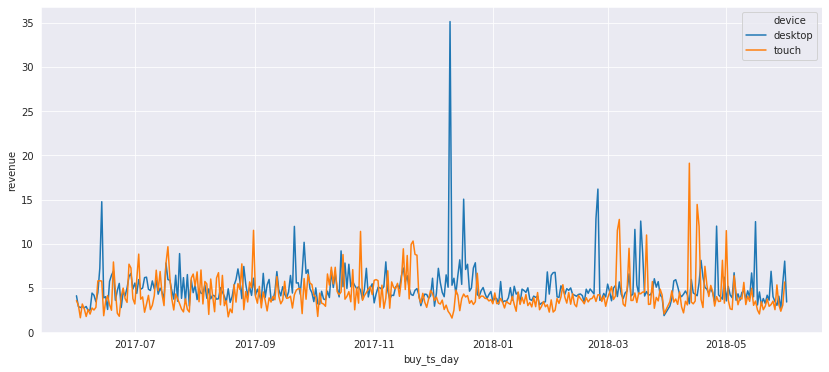

In [182]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df10 ,x = 'buy_ts_day', y = 'revenue', hue='device')

Вывод: в целом средний чек для обоих устройств имеет схожие графики изменения во времени. Средний чек на одном уровне в течение всего периода, но имеется шум и иногда пиковые значения.  Средний чек для устройства touch (4.29 р) ниже чем у desktop (5.16 р)

### 2.3.4.7 Сколько денег приносят? (LTV)

Повтрояем вычисления LTV, но с разбивкой по типу устройств

In [183]:
orders.head(2)

,buy_ts,revenue,uid,first_buy_ts,first_buy_ts_month,cohort_lifetime,buy_ts_day,buy_ts_month,source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0,2017-06-01,2017-06-01,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0,2017-06-01,2017-06-01,2,desktop


In [184]:
cohort_sizes_device = orders.groupby(['device','first_buy_ts_month'])['uid'].nunique().reset_index()
cohort_sizes_device.rename(columns={'uid':'n_buyers'}, inplace=True)
cohort_sizes_device.head(2)

,device,first_buy_ts_month,n_buyers
0,desktop,2017-06-01,1702
1,desktop,2017-07-01,1526


In [185]:
cohorts_orders_device = orders.groupby(['device','first_buy_ts_month','buy_ts_month']).agg({'revenue':'sum'}).reset_index()
cohorts_orders_device.head(2)

,device,first_buy_ts_month,buy_ts_month,revenue
0,desktop,2017-06-01,2017-06-01,8321.37
1,desktop,2017-06-01,2017-07-01,882.43


Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [186]:
report_device = cohorts_orders_device.merge(
    cohort_sizes_device, on=['device','first_buy_ts_month'], how='left')
report_device.head(2)

,device,first_buy_ts_month,buy_ts_month,revenue,n_buyers
0,desktop,2017-06-01,2017-06-01,8321.37,1702
1,desktop,2017-06-01,2017-07-01,882.43,1702


Вычисляем валовую прибыль "gross_profit" и возраст когорты "age"

In [187]:
report_device['gross_profit'] = report_device['revenue'] * MARGIN_RATE
report_device['age'] = ((report_device['buy_ts_month'] - 
                  report_device['first_buy_ts_month']) / np.timedelta64(1,'M')).round().astype('int')
report_device.head(2)

,device,first_buy_ts_month,buy_ts_month,revenue,n_buyers,gross_profit,age
0,desktop,2017-06-01,2017-06-01,8321.37,1702,8321.37,0
1,desktop,2017-06-01,2017-07-01,882.43,1702,882.43,1


Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде сводной таблицы:

In [188]:
report_device['ltv'] = report_device['gross_profit'] / report_device['n_buyers']
report_device.head(2)

,device,first_buy_ts_month,buy_ts_month,revenue,n_buyers,gross_profit,age,ltv
0,desktop,2017-06-01,2017-06-01,8321.37,1702,8321.37,0,4.889172
1,desktop,2017-06-01,2017-07-01,882.43,1702,882.43,1,0.518467


Посчитаем ltv для каждого устройства

In [189]:
output_device_touch_ltv = report_device.query('device=="touch"').pivot_table(
                        index = 'first_buy_ts_month',
                        columns = 'age', 
                        values = 'ltv',
                        aggfunc='mean')
output_device_touch_ltv.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,3.850841,0.309626,0.126604,0.0816511,0.235857,0.0409034,0.0406542,0.0228349,0.0475078,0.155732,0.0646729,0.26271
2017-07-01,5.512065,0.214836,0.0572544,0.493804,0.174383,0.139698,0.0575567,0.128136,0.0739295,0.0961965,0.123325,
2017-08-01,5.368203,0.131758,0.191133,0.144492,0.0656641,0.251758,0.135117,0.115156,0.0567969,0.0917578,,
2017-09-01,5.041130,1.87079,0.942739,0.507663,0.0776437,0.185172,1.3967,0.271303,0.047069,,,
2017-10-01,4.450149,0.429839,0.11802,0.0562129,0.13177,0.0317574,0.0236386,0.0594678,,,,
2017-11-01,5.851457,0.186887,0.0630464,0.086702,0.0844901,0.0273775,0.0280927,,,,,
2017-12-01,4.171501,0.172302,0.0706546,0.0590971,0.013781,0.0304515,,,,,,
2018-01-01,3.851087,0.108827,0.0826323,0.0680258,0.029299,,,,,,,
2018-02-01,4.052062,0.154645,0.0360664,0.0212204,,,,,,,,


In [190]:
output_device_desktop_ltv = report_device.query('device=="desktop"').pivot_table(
                        index = 'first_buy_ts_month',
                        columns = 'age', 
                        values = 'ltv',
                        aggfunc='mean')
output_device_desktop_ltv.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,4.889172,0.518467,0.496298,1.11932,1.1709,0.866504,1.12203,0.686974,0.64859,0.69067,0.666804,0.255752
2017-07-01,6.139817,0.366527,0.770852,0.323899,0.177418,0.160301,0.136507,0.14538,0.183945,0.1604,0.164089,
2017-08-01,5.255449,0.55018,0.519919,0.447989,0.592496,0.290844,0.228025,0.471616,0.346311,0.21009,,
2017-09-01,5.797504,0.926634,0.413992,4.85504,0.482424,0.764167,0.525386,0.236013,0.218723,,,
2017-10-01,5.130374,0.559994,0.20818,0.180235,0.156087,0.140631,0.0988109,0.128281,,,,
2017-11-01,4.996515,0.447435,0.230544,0.379035,0.162432,0.0598948,0.134639,,,,,
2017-12-01,4.881767,0.282688,1.14158,1.3202,0.388722,0.415979,,,,,,
2018-01-01,4.210019,0.343362,0.362221,0.162319,0.0714286,,,,,,,
2018-02-01,4.188536,0.315447,0.0912789,0.090057,,,,,,,,


Покажем ltv с накопительным эффектом для каждого устройства:

In [191]:
output_device_touch_ltv.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,3.85,4.16,4.29,4.37,4.6,4.65,4.69,4.71,4.76,4.91,4.98,5.24
2017-07-01,5.51,5.73,5.78,6.28,6.45,6.59,6.65,6.78,6.85,6.95,7.07,
2017-08-01,5.37,5.5,5.69,5.84,5.9,6.15,6.29,6.4,6.46,6.55,,
2017-09-01,5.04,6.91,7.85,8.36,8.44,8.63,10.02,10.29,10.34,,,
2017-10-01,4.45,4.88,5,5.05,5.19,5.22,5.24,5.3,,,,
2017-11-01,5.85,6.04,6.1,6.19,6.27,6.3,6.33,,,,,
2017-12-01,4.17,4.34,4.41,4.47,4.49,4.52,,,,,,
2018-01-01,3.85,3.96,4.04,4.11,4.14,,,,,,,
2018-02-01,4.05,4.21,4.24,4.26,,,,,,,,


In [192]:
output_device_desktop_ltv.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,4.89,5.41,5.9,7.02,8.19,9.06,10.18,10.87,11.52,12.21,12.88,13.13
2017-07-01,6.14,6.51,7.28,7.6,7.78,7.94,8.08,8.22,8.4,8.57,8.73,
2017-08-01,5.26,5.81,6.33,6.77,7.37,7.66,7.88,8.36,8.7,8.91,,
2017-09-01,5.80,6.72,7.14,11.99,12.48,13.24,13.77,14,14.22,,,
2017-10-01,5.13,5.69,5.9,6.08,6.23,6.38,6.47,6.6,,,,
2017-11-01,5.00,5.44,5.67,6.05,6.22,6.28,6.41,,,,,
2017-12-01,4.88,5.16,6.31,7.63,8.01,8.43,,,,,,
2018-01-01,4.21,4.55,4.92,5.08,5.15,,,,,,,
2018-02-01,4.19,4.5,4.6,4.69,,,,,,,,


Покажем ltv с накопительным эффектом для каждого устройства на тепловой карте:

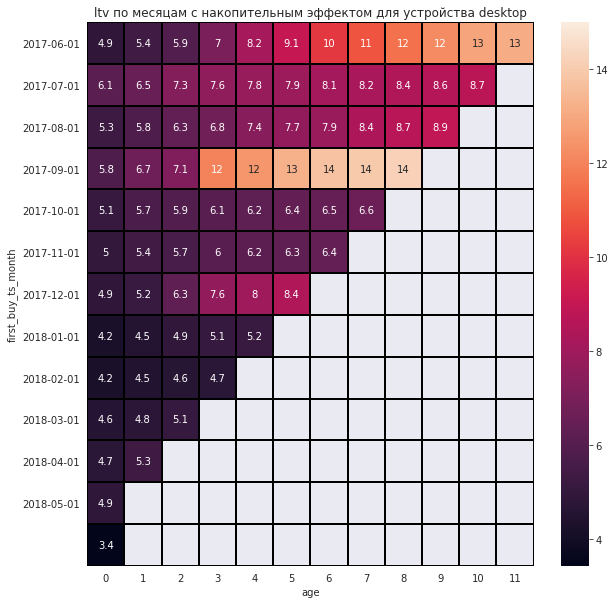

In [193]:
plt.figure(figsize=(10, 10))
plt.title('ltv по месяцам c накопительным эффектом для устройства desktop')
a = sns.heatmap(output_device_desktop_ltv.cumsum(axis=1).round(2), annot=True, 
                linewidths=1, linecolor='black', vmax=15,
               yticklabels = df2.start_ts_month.apply(lambda x: x.date()));

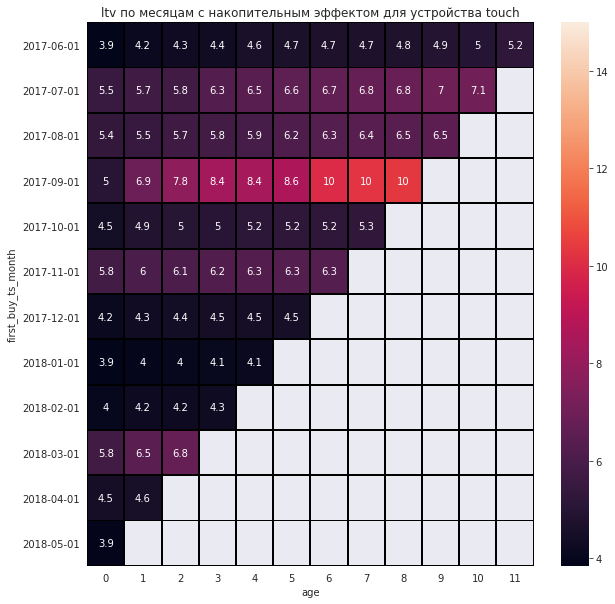

In [194]:
plt.figure(figsize=(10, 10))
plt.title('ltv по месяцам c накопительным эффектом для устройства touch')
a = sns.heatmap(output_device_touch_ltv.cumsum(axis=1).round(2), annot=True, 
                linewidths=1, linecolor='black', vmax=15,
               yticklabels = df2.start_ts_month.apply(lambda x: x.date()));

_Рев 2. LTV следует считать за период. В качестве периода возьмем 6 месяцев (тогда в рассмотрении остается 7 когорт) и посчитаем средний LTV за этот период по когортам_

Делаем срез: когорты с периодом 6 месяцев

In [195]:
output_device_desktop_ltv_6month =  output_device_desktop_ltv.cumsum(
    axis=1).round(2).loc['2017-06-01':'2017-12-01', 0:5]

output_device_touch_ltv_6month =  output_device_touch_ltv.cumsum(
    axis=1).round(2).loc['2017-06-01':'2017-12-01', 0:5]

display(output_device_desktop_ltv_6month)
display(output_device_touch_ltv_6month)

age,0,1,2,3,4,5
first_buy_ts_month,,,,,,
2017-06-01,4.89,5.41,5.90,7.02,8.19,9.06
2017-07-01,6.14,6.51,7.28,7.60,7.78,7.94
2017-08-01,5.26,5.81,6.33,6.77,7.37,7.66
2017-09-01,5.80,6.72,7.14,11.99,12.48,13.24
2017-10-01,5.13,5.69,5.90,6.08,6.23,6.38
2017-11-01,5.00,5.44,5.67,6.05,6.22,6.28
2017-12-01,4.88,5.16,6.31,7.63,8.01,8.43


age,0,1,2,3,4,5
first_buy_ts_month,,,,,,
2017-06-01,3.85,4.16,4.29,4.37,4.60,4.65
2017-07-01,5.51,5.73,5.78,6.28,6.45,6.59
2017-08-01,5.37,5.50,5.69,5.84,5.90,6.15
2017-09-01,5.04,6.91,7.85,8.36,8.44,8.63
2017-10-01,4.45,4.88,5.00,5.05,5.19,5.22
2017-11-01,5.85,6.04,6.10,6.19,6.27,6.30
2017-12-01,4.17,4.34,4.41,4.47,4.49,4.52


Вычисляем среднее LTV по когортам за 6 месяцев

In [196]:
round(output_device_desktop_ltv_6month[5].mean(),3)

8.427

In [197]:
round(output_device_touch_ltv_6month[5].mean(),3)

6.009

Вывод: средний LTV за 6 месяцев для устойства desktop в среднем выше, чем у touch
### далее строим графики с разбивкой по источникам, а не по устройствам
### 2.3.4.8 Сколько денег потратили? Всего / на каждый источник / по времени  
В данном пункте уже все построено/ посчитано. См соответствующий пункт выше.

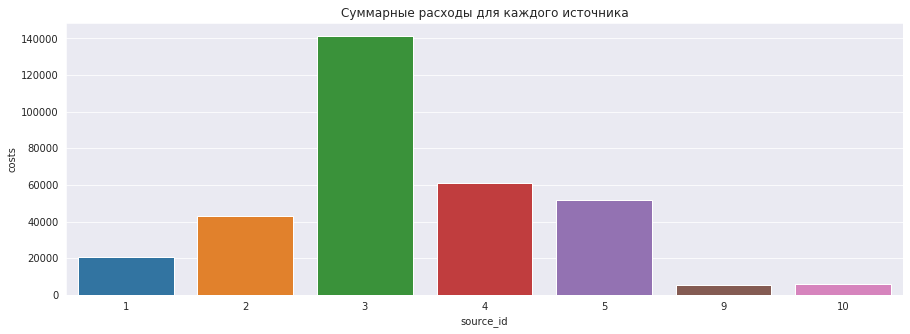

In [198]:
plt.figure(figsize=(15,5))
plt.title('Суммарные расходы для каждого источника')
sns.barplot(data=costs_per_sources, x='source_id', y='costs')

Также покажем траты по дням для каждого источника:

In [199]:
df11 = costs.groupby(['source_id','dt_days'])['costs'].sum().reset_index()
df11.head(2)

,source_id,dt_days,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25


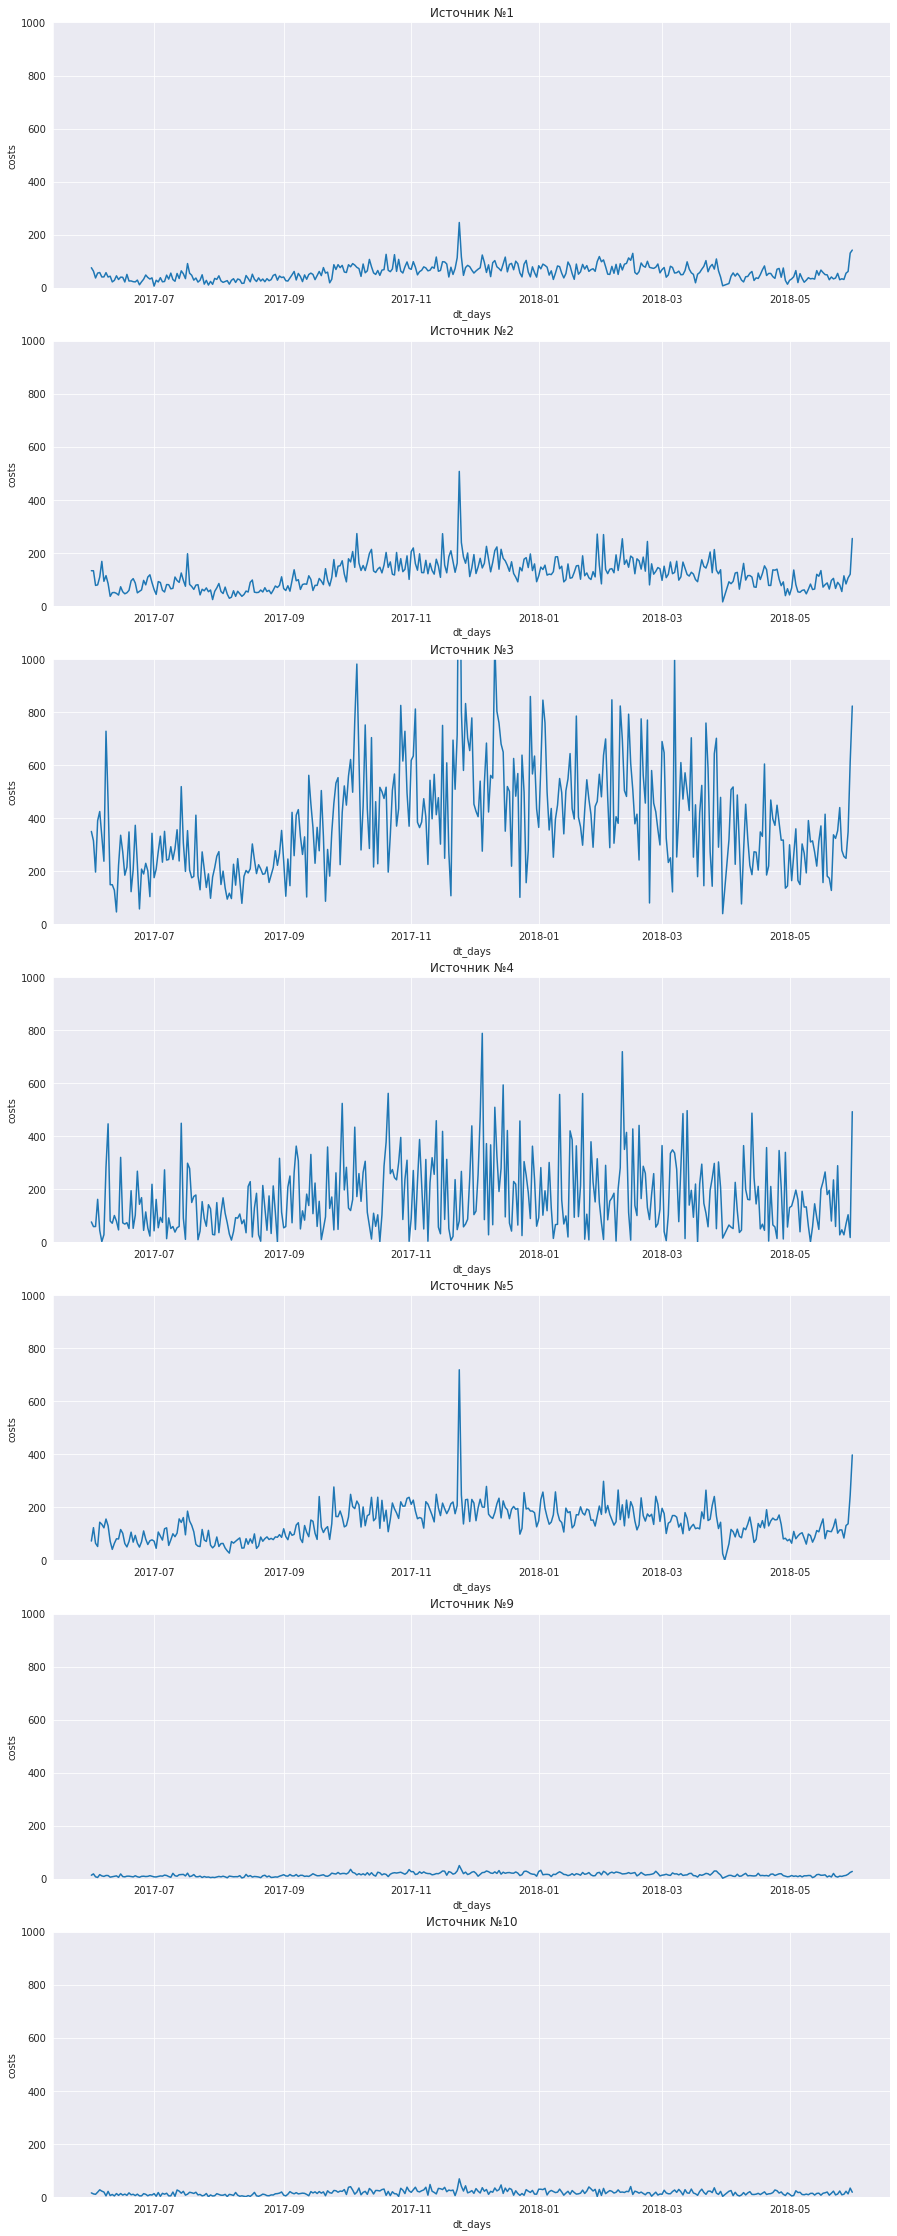

In [200]:
list_os_sources = costs['source_id'].unique()

titles = ['Источник №1', 'Источник №2', 'Источник №3', 'Источник №4',
          'Источник №5', 'Источник №9',  'Источник №10']

fig , ax = plt.subplots(len(list_os_sources),1, figsize=(15, 40))

for i in range(len(list_os_sources)):
    sns.lineplot(data=df11[df11['source_id'] == list_os_sources[i]], x ='dt_days', y='costs', ax = ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_ylim(0,1000)

### 2.3.4.9 Сколько стоило привлечение одного покупателя из каждого источника?

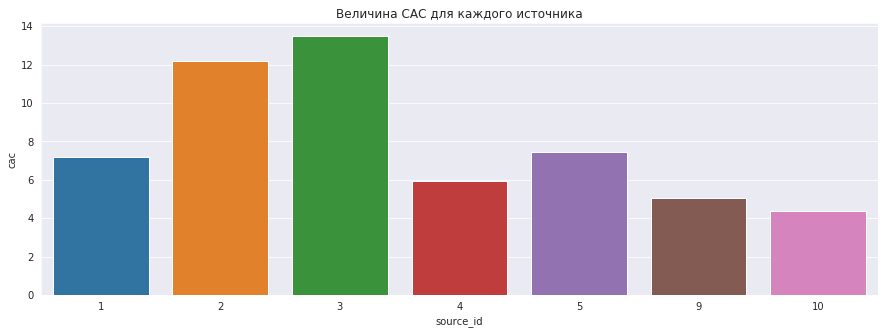

In [201]:
plt.figure(figsize=(15,5))
plt.title('Величина CAC для каждого источника')
sns.barplot(data=users_per_sources, x = 'source_id',y = 'cac')

In [202]:
users_per_sources

,source_id,n_users,costs,cac,revenue_per_source,ltv,roi
0,1,2899,20833.27,7.186364,31090.55,10.724577,1.492351
1,2,3506,42806.04,12.209367,46923.61,13.383802,1.096191
2,3,10473,141321.63,13.493901,54511.24,5.204931,0.385725
3,4,10296,61073.60,5.931779,56696.83,5.506685,0.928336
4,5,6931,51757.10,7.467479,52624.02,7.592558,1.016750
5,9,1088,5517.49,5.071222,5759.40,5.293566,1.043844
6,10,1329,5822.49,4.381106,4450.33,3.348631,0.764335


### 2.3.4.10 На сколько окупились расходы? (ROI)?

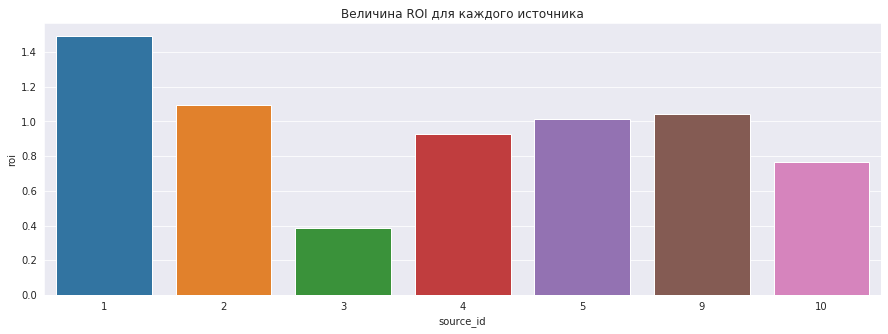

In [203]:
plt.figure(figsize=(15,5))
plt.title('Величина ROI для каждого источника')
sns.barplot(data=users_per_sources, x = 'source_id',y = 'roi')

# Шаг 3. Выводы, рекомендации маркетологам

Выведем результаты анализа по типу устройства в виде таблицы:

In [204]:
final_results_device = pd.DataFrame({
   # Среднее количество пользователей в день:
    'n_users_day_mean':[round(df0.uid.mean(),2) , round(df5.desktop,2), round(df5.touch,2)],
   # Среднее количество пользователей в неделю:
    'n_users_week_mean':[round(df1.uid.mean(),2) , round(df6.desktop,2), round(df6.touch,2)],
  # Среднее количество пользователей в месяц:
    'n_users_month_mean':[round(df1.uid.mean(),2) , round(df7.desktop,2), round(df7.touch,2)],
   # Среднее количество сессий в день на 1 пользователя:
    'session_per_day_mean': [session_per_day_mean, round(df8.desktop,2), round(df8.touch,2)],
 # Средняя продолжительность сессий в день на 1 пользователя:
    'duration_ts': [duration_ts_mean, round(df9.desktop,2), round(df9.touch,2)], 
 # Средний retention rate в месяц, рассчитанный за период 6 месяцев для когорт,
 # по которым есть данные за 6 месяцев:
    'retention_rate_mean_6month': [round(np.nanmean(retention_pivot_6month),3),
                                  round(np.nanmean(retention_pivot_desktop_6month),3),
                                  round(np.nanmean(retention_pivot_touch_6month),3)],
                                    
    # Когда люди начинают покупать с момента начала сессии (в днях)
    'days_before_buying' : [first_orders_visits['days_before_buying'].median(),
                first_orders_visits.query('device == "desktop"')['days_before_buying'].median(),
                first_orders_visits.query('device == "touch"')['days_before_buying'].median()],
    # Сколько раз покупают за период 6 месяцев
    'orders_per_6month_mean' : [round(orders_pivot_slice.sum(axis=1).mean(),3),
                               round(orders_pivot_desktop_slice.sum(axis=1).mean(),3),
                               round(orders_pivot_touch_slice.sum(axis=1).mean(),3)],
   # Средний чек
    'mean_bill' : [round(orders['revenue'].mean(),3),
                   round(orders.groupby('device')['revenue'].mean().desktop,3),
                   round(orders.groupby('device')['revenue'].mean().touch,3)],
    # LTV средний за 6 месяцев
    'ltv_mean_6month' : [round(output_ltv_6months[5].mean(),3),
            round(output_device_desktop_ltv_6month[5].mean(),3),
             round(output_device_touch_ltv_6month[5].mean(),3)],    
                                    }, index = ['total', 'desktop', 'touch'])
                                            
final_results_device.T

,total,desktop,touch
n_users_day_mean,907.990000,721.340,266.750
n_users_week_mean,5716.250000,4954.090,1827.020
n_users_month_mean,5716.250000,21880.580,8069.330
session_per_day_mean,1.080000,1.090,1.050
duration_ts,643.025687,681.070,463.670
retention_rate_mean_6month,0.055000,0.058,0.047
days_before_buying,0.000000,0.000,0.000
orders_per_6month_mean,4210.857000,3447.000,763.857
mean_bill,5.000000,5.164,4.293
ltv_mean_6month,7.970000,8.427,6.009


Также выведем средний ROMI за 6 месяцев:

In [205]:
romi_6month_mean

0.86

Также выведем вычисленные метрики по источникам
- source_id - номер источника;
- n_users - количество поллзователей;
- суммарные расходы;
- revenue_per_source - выручка с источника

In [206]:
users_per_sources

,source_id,n_users,costs,cac,revenue_per_source,ltv,roi
0,1,2899,20833.27,7.186364,31090.55,10.724577,1.492351
1,2,3506,42806.04,12.209367,46923.61,13.383802,1.096191
2,3,10473,141321.63,13.493901,54511.24,5.204931,0.385725
3,4,10296,61073.60,5.931779,56696.83,5.506685,0.928336
4,5,6931,51757.10,7.467479,52624.02,7.592558,1.016750
5,9,1088,5517.49,5.071222,5759.40,5.293566,1.043844
6,10,1329,5822.49,4.381106,4450.33,3.348631,0.764335


Выводы:  
1. Тип устройства "desktop" превосходит тип устройства "touch" по ВСЕМ измеренным метрикам:   количество посетителей, количество сессий, прододжительности сессий, retention_rate, количество покупок за период 6 мес, средний чек, ltv.    Единственный почти одинаковый у устройств параметр - "через сколько люди покупают" - для обоих устройств покупка в среднем происходит в тот же день, что и первая сессия.
2. Средний ROMI за 6 месяцев составил 86%. Т.е. за 6 месяцев расходы себя не окупили. Необходимо получить больше данных и посмотреть ROMI за больший промежуток времени, чтобы оценить - является ли приложение прибыльным. 
3. Проанализировав расходы на маркетинг выяснили: 
 - окупились и принесли прибыль следующие источники (ROI > 1):  1,2,5,9.  
 - источник 9 - работает почти в ноль,  прибыль - 1.6%.
 - неокупились источники (ROI < 1):  3, 4, 10.
 - отдельно стоит отметить источник 3, у которого самый низкий ROI = 0.386 при самых высоких расходах 131322 руб (43% от общих расходов). 
 
4. В первую очередь надо получить больше данных и проверить что ROMI на большем интервале становится > 1, т.е. приложение приносит прибыль.  Также однозначно стоит вкладывать больше денег в "desktop", чем в "touch". А также стоит вкладываться в источники 1,2,5. Источник 9 стоит детально проверить - он работает почти в ноль.   Необходимо пересмотреть работу источников 3,4,10 (особенно 3-ий, который самый затратный) которые себя не окупили.
        